### Data Loader and Preprocessor:
Purpose: Handles data loading, preprocessing, and splitting into train/test sets.
Methods: Load data, preprocess data, split data.

### Analysis and Statistics:
Purpose: Provides statistical analysis and reporting on the dataset.
Methods: General stats, null rate calculation, metadata contribution and more..

### Visualization:
Purpose: Creates visualizations for data exploration and results.
Methods: Plot distributions, spam vs non-spam visualizations.

### Project manager + models:
Purpose: Contains general utility functions that may be useful across the project.
Methods: Save models, load models, export results.

# Part A

## 1. Imports

In [1]:
!pip install datasets
!pip install pytorch_lightning
!pip install torch torchvision

# pip install memory_profiler
# pip install xgboost==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.8 MB/

In [2]:
# Standard library imports
print("Script started")
import os
import warnings

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn for classic machine learning and preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# TextBlob for sentiment analysis
from textblob import TextBlob

# PyTorch and related utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.quantization
from torch.utils.data import DataLoader, Dataset, TensorDataset

# PyTorch Lightning
import pytorch_lightning as pl
import torchmetrics

# Transformers and Datasets for NLP models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import Dataset

# TensorFlow and Keras for additional deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# XGBoost for gradient boosting
import xgboost as xgb

# Working with Google Colab (if applicable)
from google.colab import drive
print("Imports part is finished")


Script started
Imports part is finished


## 2. Classes

### Data Loader & Preprocessor



In [3]:
class DataLoaderAndPreprocessor:
    def __init__(self, data_path):
        # Initializing with the data path
        self.data_path = data_path
        self.raw_df_dict = self.load_data_from_dir()  # Loading data from directory
        self.original_data_dict = self.raw_df_dict.copy()  # Backing up original data

    def load_data(self, file_name):
        # Loading individual CSV file
        df = pd.read_csv(f"{self.data_path}/{file_name}")
        print(f"Loaded {file_name} with shape: {df.shape}")
        return df

    def load_data_from_dir(self):
        # Loading all CSV files from directory
        data_dict = {}
        for file_name in os.listdir(self.data_path):
            if file_name.endswith('.csv'):
                data_dict[file_name] = self.load_data(file_name)
        print(f"Data loaded from directory: {list(data_dict.keys())}")
        return data_dict

    def concat_dataframes(self, exclude_df_name):
        # Concatenating DataFrames, excluding one specified
        all_columns = set()

        # Collecting all columns from DataFrames except the one to exclude
        for df_name, df in self.raw_df_dict.items():
            if df_name != exclude_df_name:
                all_columns.update(df.columns)

        all_columns = list(all_columns)
        print(f"Columns being used for concatenation: {all_columns}")

        # Ensuring each DataFrame has all columns, filling missing ones with NaN
        def ensure_columns(df, columns, source_name):
            for col in columns:
                if col not in df.columns:
                    df[col] = np.nan
            df['source'] = source_name
            return df[columns + ['source']]

        # Preparing and concatenating DataFrames excluding the specified one
        concatenated_df = pd.DataFrame(columns=all_columns + ['source'])
        for df_name, df in self.raw_df_dict.items():
            if df_name != exclude_df_name:
                print(f"Before concatenation {df_name} shape: {df.shape}")
                df = ensure_columns(df, all_columns, df_name)
                concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
                print(f"After concatenation {df_name} concatenated_df shape: {concatenated_df.shape}")

        print(f"Final shape of concatenated_df: {concatenated_df.shape}")
        return concatenated_df

    def preprocess_data(self, df):
        # Preprocessing data through multiple steps
        print(f"Initial shape of df in preprocess_data: {df.shape}")
        df = self.handle_missing_values(df)
        print(f"Shape after handling missing values: {df.shape}")
        df = self.handle_outliers(df)
        print(f"Shape after handling outliers: {df.shape}")
        df = self.normalize_features(df)
        print(f"Shape after normalizing features: {df.shape}")
        df = self.encode_features(df)
        print(f"Shape after encoding features: {df.shape}")
        df = self.convert_datetime(df)
        print(f"Shape after converting datetime: {df.shape}")
        df = self.text_preprocessing(df)
        print(f"Shape after text preprocessing: {df.shape}")
        return df

    def handle_missing_values(self, df):
        # Handling missing values in 'subject' and 'body' columns
        df.loc[:, 'subject'].fillna('No Subject', inplace=True)
        df.loc[:, 'body'].fillna('No Body', inplace=True)
        return df

    def handle_outliers(self, df):
        # Handling outliers in 'urls' column
        if 'urls' in df.columns:
            df.loc[:, 'urls'] = df['urls'].clip(lower=df['urls'].quantile(0.01), upper=df['urls'].quantile(0.99))
        return df

    def normalize_features(self, df):
        # Normalizing 'urls' column
        if 'urls' in df.columns:
            scaler = StandardScaler()
            df.loc[:, ['urls']] = scaler.fit_transform(df[['urls']])
        return df

    def encode_features(self, df):
        # Encoding 'label' column
        if 'label' in df.columns:
            label_encoder = LabelEncoder()
            df.loc[:, 'label'] = label_encoder.fit_transform(df['label'])
        return df

    def convert_datetime(self, df):
        # Converting 'date' column to datetime
        if 'date' in df.columns:
            df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
        return df

    def text_preprocessing(self, df):
        # Preprocessing text in 'body' column
        df.loc[:, 'body'] = df['body'].apply(self.clean_text)
        return df

    def clean_text(self, text):
        # Cleaning text by removing stopwords and non-alphanumeric characters
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        cleaned_text = ' '.join([word for word in tokens if word.isalnum() and word not in stop_words])
        return cleaned_text

    def preprocess_data_dict(self):
        # Preprocessing all DataFrames in the dictionary
        processed_dict = {}
        for key, df in self.raw_df_dict.items():
            processed_dict[key] = self.preprocess_data(df)
        return processed_dict

    @staticmethod
    def cast_columns(df, col_name, dtype):
      # Cast columns to appropriate types
      try:
        if col_name in df.columns:
          if dtype == 'date':
              df[col_name] = pd.to_datetime(df[col_name], errors='coerce', utc=True)
          else:
            df[col_name] = df[col_name].astype(dtype)
        return df
      except Exception as e:
        raise ValueError(f'see the {e}')

    def update_original_data(self):
        # Updating the backup of the original data
        self.original_data_dict = self.raw_df_dict.copy()

### AnalysisAndStatistics

In [4]:
class AnalysisAndStatistics:
    def __init__(self, raw_df):
      self.raw_df = raw_df

    def df_general_stats(self) -> None:
      print(f"--- General Info ---\n")
      print(f"{self.raw_df.info()}\n")
      print(f"--- Statistics ---\n")
      print(f"{self.raw_df.describe()}\n")

    def nulls_rate_per_col(self, df_cols: list) -> None:
      for col in df_cols:
        nulls = self.raw_df[col].isnull().sum()
        df_length = self.raw_df.shape[0]
        calc = round(nulls / df_length * 100, 2)
        print(f"The null rate of {col} column: {calc}%")
        print(f"Number of nulls: {nulls}, number of rows: {df_length}\n")

    def metadata_contribution(self, df_col: str):
      print(f"--- Metadata Contribution by {df_col} ---\n")
      df_filtered = self.raw_df[self.raw_df[df_col].notnull()]
      pivot = df_filtered.groupby(df_col)['label'].agg(spam_sum='sum', spam_count='count').reset_index()
      pivot['df_length'] = df_filtered.shape[0]
      pivot['internal_spam_rate'] = pivot['spam_sum'] / pivot['spam_count']
      pivot['total_spam_rate'] = pivot['spam_sum'] / pivot['df_length']
      pivot['internal_spam_rate'] = pd.to_numeric(pivot['internal_spam_rate'], errors='coerce').fillna(0).astype(float).round(2)
      pivot['total_spam_rate'] = pd.to_numeric(pivot['total_spam_rate'], errors='coerce').fillna(0).astype(float).round(2)
      print(f"{pivot}")

    def analyze_word_count(self):
        # Analyzing word count in 'body' column
        self.raw_df.loc[:, 'word_count'] = self.raw_df['body'].apply(lambda x: len(x.split()))
        pivot = self.raw_df.groupby('word_count')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_char_count(self):
        self.raw_df.loc[:, 'char_count'] = self.raw_df['body'].apply(lambda x: len([c for c in x if not c.isalnum()])).astype(int)
        pivot = self.raw_df.groupby('char_count')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_body_capital_ratio(self):
        self.raw_df.loc[:, 'capital_count'] = self.raw_df['body'].apply(lambda x: len([c for c in x if c.isupper()])).astype(int)
        self.raw_df.loc[:, 'capital_ratio'] = (self.raw_df['capital_count'] / self.raw_df['body'].apply(len)).astype(float)
        pivot = self.raw_df.groupby('capital_ratio')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_email_domains(self):
        self.raw_df.loc[:, 'domain'] = self.raw_df['sender'].apply(lambda x: x.split('@')[-1] if pd.notnull(x) else '')
        pivot = self.raw_df.groupby('domain')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_attachments(self):
        self.raw_df.loc[:, 'has_attachment'] = self.raw_df['body'].apply(lambda x: 'attachment' in x.lower()).astype(int)
        pivot = self.raw_df.groupby('has_attachment')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_time_features(self):
        # Filter valid dates and create time-related features
        df_valid = self.raw_df.loc[~self.raw_df['date'].isna(), :].copy()  # Ensures you're working with a full copy
        self.raw_df['hour'] = pd.NA
        self.raw_df['weekday'] = pd.NA
        self.raw_df['week'] = pd.NA

        # Safely assign time-related features
        self.raw_df.loc[df_valid.index, 'hour'] = df_valid['date'].dt.hour.astype(int)
        self.raw_df.loc[df_valid.index, 'weekday'] = df_valid['date'].dt.weekday.astype(int)
        self.raw_df.loc[df_valid.index, 'week'] = df_valid['date'].dt.isocalendar().week.astype(int)

        # Print the spam rates by the new time features
        for feature in ['hour', 'weekday', 'week']:
            pivot = self.raw_df.groupby(feature)['label'].agg(spam_sum='sum', spam_count='count').reset_index()
            pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
            print(f"Spam rate by {feature}:\n{pivot}\n")

    def analyze_ngrams(self, n: int = 1):
        vectorizer = CountVectorizer(ngram_range=(n, n))
        X = vectorizer.fit_transform(self.raw_df['body'])
        ngram_counts = X.toarray().sum(axis=0)
        ngram_names = vectorizer.get_feature_names_out()
        ngrams = pd.DataFrame({'ngram': ngram_names, 'count': ngram_counts})
        print(f"Top {n}-grams:")
        print(ngrams.head(20))

    def analyze_sentiment(self):
        # Ensure 'body' is treated as a string and handle NaN or empty values
        self.raw_df['body'] = self.raw_df['body'].fillna('').astype(str)

        # Calculate sentiment using TextBlob
        self.raw_df['sentiment'] = self.raw_df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

        # Pivot and calculate spam rates
        pivot = self.raw_df.groupby('sentiment')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(f"Spam rate by sentiment polarity:\n{pivot}\n")


### Visualizations

In [5]:
class Visualization:
    def __init__(self, raw_df):
        self.raw_df = raw_df  # Use raw_df instead of df

    @staticmethod
    def escape_special_characters(series):
        special_chars = ['$', '_', '&', '%', '<', '>', '{', '}', '#']
        for char in special_chars:
            series = series.str.replace(char, '\\' + char, regex=True)
        return series

    def plot_correlation_matrix(self):
        numeric_df = self.raw_df.select_dtypes(include=[float, int])
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    def plot_word_count_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['word_count'], kde=True)  # Uses precomputed 'word_count'
        plt.xscale('log')
        plt.title('Word Count Distribution')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_word_count_boxplot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=self.raw_df['word_count'])  # Uses precomputed 'word_count'
        plt.xscale('log')
        plt.title('Word Count Distribution Boxplot')
        plt.xlabel('Word Count')
        plt.grid(True)
        plt.show()

    def plot_word_count_boxplot_by_label(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y='word_count', data=self.raw_df)  # Uses precomputed 'word_count'
        plt.yscale('log')
        plt.title('Word Count Distribution Boxplot by Label')
        plt.xlabel('Label')
        plt.ylabel('Word Count')
        plt.grid(True)
        plt.show()

    def plot_char_count_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['char_count'], kde=True)  # Uses precomputed 'char_count'
        plt.xscale('log')
        plt.title('Character Count Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_char_count_boxplot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y='char_count', data=self.raw_df)  # Uses precomputed 'char_count'
        plt.yscale('log')
        plt.title('Character Count Distribution Boxplot by Label')
        plt.xlabel('Label')
        plt.ylabel('Character Count')
        plt.grid(True)
        plt.show()

    def plot_capital_ratio_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['capital_ratio'], kde=True)  # Uses precomputed 'capital_ratio'
        plt.title('Capital Letter Ratio Distribution')
        plt.xlabel('Capital Letter Ratio')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.ylim(0, 5000)
        plt.show()

    def plot_ngram_distribution(self, n=1):
        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngrams = vectorizer.fit_transform(self.raw_df['body'])
        ngram_counts = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())
        ngram_sum = ngram_counts.sum().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=ngram_sum.values, y=ngram_sum.index)
        plt.title(f'Top {n}-grams')
        plt.xlabel('Frequency')
        plt.ylabel(f'{n}-gram')
        plt.grid(True)
        plt.show()

    def plot_sentiment_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['sentiment'], kde=True)
        plt.title('Sentiment Polarity Distribution')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.ylim(0, 4000)
        plt.show()

    def plot_spam_rate_by_time(self, time_feature):
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=time_feature, y='label', data=self.raw_df)  # Uses precomputed time features ('hour', 'weekday', 'week')
        plt.title(f'Spam Rate by {time_feature.capitalize()}')
        plt.xlabel(time_feature.capitalize())
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()


    def plot_spam_rate_by_metadata(self, column, top_n=10):
        if column not in self.df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            return

        # Calculate the frequency of each value in the column
        unique_values_count = self.df[column].nunique()
        if top_n > unique_values_count:
            print(f"Requested top_n ({top_n}) exceeds the number of unique values ({unique_values_count}). Adjusting top_n to {unique_values_count}.")
            top_n = unique_values_count

        # Calculate the frequency of each domain
        top_in_cols = self.df[column].value_counts().nlargest(top_n).index

        # Filter only top N
        filtered_df = self.df[self.df[column].isin(top_in_cols)]

        if filtered_df.empty:
            print(f"No data available for plotting after filtering with top_n = {top_n}.")
            return

        # Calculate spam rate
        pivot = filtered_df.groupby(column)['label'].mean().reset_index()

        # Plot the spam rate
        plt.figure(figsize=(10, 6))
        sns.barplot(x=column, y='label', data=pivot)
        plt.title(f'Spam Rate by {column} (Top {top_n})')
        plt.xlabel(column.capitalize())
        plt.ylabel('Spam Rate')
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.show()


    def plot_avg_word_count_by_label(self):
        avg_word_count = self.raw_df.groupby('label')['word_count'].mean().reset_index()  # Uses precomputed 'word_count'
        plt.figure(figsize=(10, 6))
        sns.barplot(x='label', y='word_count', data=avg_word_count)
        plt.title('Average Word Count by Label')
        plt.xlabel('Label')
        plt.ylabel('Average Word Count')
        plt.grid(True)
        plt.show()

    def plot_max_word_count_by_label(self):
        max_word_count = self.raw_df.groupby('label')['word_count'].max().reset_index()  # Uses precomputed 'word_count'
        plt.figure(figsize=(10, 6))
        sns.barplot(x='label', y='word_count', data=max_word_count)
        plt.title('Max Word Count by Label')
        plt.xlabel('Label')
        plt.ylabel('Max Word Count')
        plt.grid(True)
        plt.show()

    # def compare_distributions(self, column, hue):
    #     self.raw_df[hue] = self.escape_special_characters(self.raw_df[hue].astype(str))
    #     plt.figure(figsize=(10, 6))
    #     sns.countplot(x=column, hue=hue, data=self.raw_df)
    #     plt.title(f'Distribution of {column} by {hue}')
    #     plt.xlabel(column)
    #     plt.ylabel('Count')
    #     plt.legend(title=hue)
    #     plt.grid(True)
    #     plt.show()

    # def plot_spam_rate_by_metadata(self, column):
    #     self.raw_df[column] = self.escape_special_characters(self.raw_df[column].astype(str))
    #     pivot = self.raw_df.groupby(column)['label'].mean().reset_index()
    #     plt.figure(figsize=(10, 6))
    #     sns.barplot(x=column, y='label', data=pivot)
    #     plt.title(f'Spam Rate by {column}')
    #     plt.xlabel(column)
    #     plt.ylabel('Spam Rate')
    #     plt.grid(True)
    #     plt.show()

    def plot_spam_rate_by_metadata(self, column):
        # This method now only uses precomputed data
        pivot = self.raw_df.groupby(column)['label'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=column, y='label', data=pivot)
        plt.title(f'Spam Rate by {column}')
        plt.xlabel(column)
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()

    def generate_word_cloud(self, text, title=None):
        wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        if title:
            plt.title(title)
        plt.show()

    def plot_word_clouds(self):
        spam_text = " ".join(self.raw_df[self.raw_df['label'] == 1]['body'])
        non_spam_text = " ".join(self.raw_df[self.raw_df['label'] == 0]['body'])

        print("Word Cloud for Spam Emails")
        self.generate_word_cloud(spam_text, "Spam Emails")

        print("Word Cloud for Non-Spam Emails")
        self.generate_word_cloud(non_spam_text, "Non-Spam Emails")

    def plot_email_length_histogram(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df[self.raw_df['label'] == 1]['word_count'], color='red', label='Spam', kde=True)
        sns.histplot(self.raw_df[self.raw_df['label'] == 0]['word_count'], color='blue', label='Non-Spam', kde=True)
        plt.title('Email Length Distribution for Spam and Non-Spam')
        plt.xlabel('Email Length')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1300)
        plt.show()

    def plot_url_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['has_urls'], kde=False, bins=2)
        plt.title('Distribution of Emails with and without URLs')
        plt.xlabel('Has URLs (0 = No, 1 = Yes)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_spam_rate_by_url(self):
        url_spam_rate = self.raw_df.groupby('has_urls')['label'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(x='has_urls', y='label', data=url_spam_rate)
        plt.title('Spam Rate by URL Presence')
        plt.xlabel('Has URLs (0 = No, 1 = Yes)')
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_epoch_roc(train_tpr, train_fpr, val_tpr, val_fpr, epoch_num):
        plt.figure(figsize=(10, 6))
        plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='Training ROC Curve')
        plt.plot(val_fpr, val_tpr, color='orange', lw=2, label='Validation ROC Curve')
        plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic in Epoch {epoch_num}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_epoch_loss(train_loss, val_loss, epoch_num):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(train_loss)), train_loss, color='blue', lw=2, label='Training Loss')
        plt.plot(range(len(val_loss)), val_loss, color='orange', lw=2, label='Validation Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Loss per Batch in Epoch {epoch_num}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

## 3. Loading The Data

In [6]:
# create mount to drivee
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Initialize data loader with the new path
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/'
data_loader = DataLoaderAndPreprocessor(data_path=file_path)
# Print the contents of the directory to verify the path
print(f"Contents of {data_loader.data_path}:")
print(os.listdir(data_loader.data_path))

Loaded CEAS_08.csv with shape: (39154, 7)
Loaded Enron.csv with shape: (29767, 3)
Loaded Nazario.csv with shape: (1565, 7)
Loaded Ling.csv with shape: (2859, 3)
Loaded SpamAssasin.csv with shape: (5809, 7)
Loaded Nigerian_Fraud.csv with shape: (3332, 7)
Loaded phishing_email.csv with shape: (82486, 2)
Data loaded from directory: ['CEAS_08.csv', 'Enron.csv', 'Nazario.csv', 'Ling.csv', 'SpamAssasin.csv', 'Nigerian_Fraud.csv', 'phishing_email.csv']
Contents of /content/drive/My Drive/deep_learning_ex1/final_project_data/:
['CEAS_08.csv', 'Enron.csv', 'Nazario.csv', 'Ling.csv', 'SpamAssasin.csv', 'Nigerian_Fraud.csv', 'phishing_email.csv', 'preprocessed_data.pkl', 'manipulated_wo_body.pkl', 'manipulated_only_body.pkl', 'raw_data.pkl']


In [8]:
# Concatenate the DataFrames excluding 'phishing_email.csv'
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = data_loader.concat_dataframes(exclude_df_name='phishing_email.csv')

Columns being used for concatenation: ['sender', 'date', 'receiver', 'body', 'subject', 'urls', 'label']
Before concatenation CEAS_08.csv shape: (39154, 7)
After concatenation CEAS_08.csv concatenated_df shape: (39154, 8)
Before concatenation Enron.csv shape: (29767, 3)
After concatenation Enron.csv concatenated_df shape: (68921, 8)
Before concatenation Nazario.csv shape: (1565, 7)
After concatenation Nazario.csv concatenated_df shape: (70486, 8)
Before concatenation Ling.csv shape: (2859, 3)
After concatenation Ling.csv concatenated_df shape: (73345, 8)
Before concatenation SpamAssasin.csv shape: (5809, 7)
After concatenation SpamAssasin.csv concatenated_df shape: (79154, 8)
Before concatenation Nigerian_Fraud.csv shape: (3332, 7)
After concatenation Nigerian_Fraud.csv concatenated_df shape: (82486, 8)
Final shape of concatenated_df: (82486, 8)


In [9]:
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'label', int)
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'urls', float)
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'date', 'date')
data_loader.raw_df_dict['phishing_email_concatenated.csv']['body'] = data_loader.raw_df_dict['phishing_email_concatenated.csv']['body'].fillna('').astype(str)

In [10]:
data_loader.raw_df_dict['phishing_email_concatenated.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   sender    49529 non-null  object             
 1   date      47525 non-null  datetime64[ns, UTC]
 2   receiver  47768 non-null  object             
 3   body      82486 non-null  object             
 4   subject   82139 non-null  object             
 5   urls      49860 non-null  float64            
 6   label     82486 non-null  int64              
 7   source    82486 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 5.0+ MB


In [11]:
# Emails with empty body
data_loader.raw_df_dict['phishing_email_concatenated.csv'][data_loader.raw_df_dict['phishing_email_concatenated.csv']['body']=='']
# single one which spam

,sender,date,receiver,body,subject,urls,label,source
77740,=?Big5?B?qfap9qXNrKG69A==?= <ee@enews.com.tw>,2002-09-11 09:19:10+00:00,undisclosed-recipients:;,,=?Big5?B?rEKq96SjrE5+fqdPtsykRn5+?=,1.0,1,SpamAssasin.csv


In [12]:
# Group by source and count rows
print("\nRows per source:")
print(data_loader.raw_df_dict['phishing_email_concatenated.csv'].groupby('source').size().reset_index(name='count'))

# Check nulls for each source
print("\nNull counts per source:")
print(data_loader.raw_df_dict['phishing_email_concatenated.csv'].isnull().groupby(data_loader.raw_df_dict['phishing_email_concatenated.csv']['source']).sum())

# Final shape of concatenated DataFrame
print(f"\nFinal shape of concatenated DataFrame: {data_loader.raw_df_dict['phishing_email_concatenated.csv'].shape}")


Rows per source:
               source  count
0         CEAS_08.csv  39154
1           Enron.csv  29767
2            Ling.csv   2859
3         Nazario.csv   1565
4  Nigerian_Fraud.csv   3332
5     SpamAssasin.csv   5809

Null counts per source:
                    sender   date  receiver  body  subject   urls  label  \
source                                                                     
CEAS_08.csv              0     15       462     0       28      0      0   
Enron.csv            29767  29767     29767     0      198  29767      0   
Ling.csv              2859   2859      2859     0       62   2859      0   
Nazario.csv              0    589        96     0        4      0      0   
Nigerian_Fraud.csv     331    482      1324     0       39      0      0   
SpamAssasin.csv          0   1249       210     0       16      0      0   

                    source  
source                      
CEAS_08.csv              0  
Enron.csv                0  
Ling.csv                 0  


## 4. Analytics and Preprocessing

### Summary Of Analysis:
* Columns like receiver, date, sender, and urls have a significant number of null
* The label column indicates the spam (1) and non-spam (0) classification, with an almost even distribution.
* The receiver, date, sender, and urls columns have a high null rate (~40%).
* The date column has many invalid datetime values (~42.38%).
* Many senders have an internal spam rate of 1.0, meaning all emails from these senders are classified as spam.
* Word Count Analysis: Higher word counts generally correlate with higher spam rates.
* Character Count Analysis: Higher character counts are also correlated with higher spam rates.
* Body Capital Ratio Analysis: Higher capital ratios are correlated with higher spam rates.
* Email Domains Analysis: Some email domains have a high spam rate.
* Attachments: Emails with attachments have a lower spam rate compared to those without attachments.
* Preprocess: shapes stay the same after

### Preprocessing steps that were taken:
* The shape of the DataFrame remains consistent at each step of the preprocessing pipeline, indicating that no rows or columns were dropped.
* Handling Missing Values: Missing values were addressed, but the overall structure of the DataFrame remained unchanged.
* Handling Outliers: Outliers were handled, likely through clipping or similar techniques, without altering the DataFrame’s dimensions.
* Normalizing Features: Numeric features were normalized to ensure they have similar scales.
* Encoding Features: Categorical features were encoded, making them suitable for machine learning models.
* Converting Datetime: The 'date' column was converted to datetime format.
* Text Preprocessing: Text data was cleaned, which typically includes operations like lowercasing, removing stopwords, and stemming/lemmatizing

In [13]:
# Create AnalysisAndStatistics object with the raw data
analytics = AnalysisAndStatistics(raw_df=data_loader.raw_df_dict['phishing_email_concatenated.csv'])

In [14]:
# Perform general statistics on the concatenated DataFrame
print(f"\n----------------- Analysis for concatenated DataFrame -----------------\n")
analytics.df_general_stats()


----------------- Analysis for concatenated DataFrame -----------------

--- General Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   sender    49529 non-null  object             
 1   date      47525 non-null  datetime64[ns, UTC]
 2   receiver  47768 non-null  object             
 3   body      82486 non-null  object             
 4   subject   82139 non-null  object             
 5   urls      49860 non-null  float64            
 6   label     82486 non-null  int64              
 7   source    82486 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 5.0+ MB
None

--- Statistics ---

               urls         label
count  49860.000000  82486.000000
mean       0.678018      0.519979
std        0.467241      0.499604
min        0.000000      0.000000
25% 

In [15]:
print("------------- Nulls Rate per Column --------------------------------------\n")
# Check null rates for the concatenated DataFrame
analytics.nulls_rate_per_col(df_cols=list(analytics.raw_df.columns))

------------- Nulls Rate per Column --------------------------------------

The null rate of sender column: 39.95%
Number of nulls: 32957, number of rows: 82486

The null rate of date column: 42.38%
Number of nulls: 34961, number of rows: 82486

The null rate of receiver column: 42.09%
Number of nulls: 34718, number of rows: 82486

The null rate of body column: 0.0%
Number of nulls: 0, number of rows: 82486

The null rate of subject column: 0.42%
Number of nulls: 347, number of rows: 82486

The null rate of urls column: 39.55%
Number of nulls: 32626, number of rows: 82486

The null rate of label column: 0.0%
Number of nulls: 0, number of rows: 82486

The null rate of source column: 0.0%
Number of nulls: 0, number of rows: 82486



In [16]:
# Metadata Contribution for phishing_email_concatenated.csv by sender
analytics.metadata_contribution('sender')

--- Metadata Contribution by sender ---

                                                  sender  spam_sum  \
0                DR. ANAYO AWKA  <anayoawka@hotmail.com>         1   
1       Please login to your Apple ID from   \t\t\t\t...         1   
2                                     "  Coinbase   " <>         1   
3                   " " <Netflix_mails@skybluefoods.net>         1   
4                    " " <Wellsfargo_Online@knology.net>         1   
...                                                  ...       ...   
31410                Шебеленко  <rucker@latinlawyer.com>         1   
31411                      Шенкаренко  <bluechip@eim.ae>         1   
31412                           ビムーブ <lmlmkex@gmail.com>         0   
31413                          新桥学术翻译机构 <gzxqfy@163.com>         2   
31414                     磊 杨 <papyucy6996@yahoo.com.cn>         0   

       spam_count  df_length  internal_spam_rate  total_spam_rate  
0               1      49529                 1.0  

In [17]:
# Analyzing word count in 'body' column
analytics.analyze_word_count()

      word_count  spam_sum  spam_count  spam_rate
0              0         5           5       1.00
1              1        38          55       0.69
2              2       604         615       0.98
3              3       108         130       0.83
4              4       116         140       0.83
...          ...       ...         ...        ...
2590       33037         0           1       0.00
2591       34898         0           1       0.00
2592       45448         0           1       0.00
2593       46575         1           1       1.00
2594      127119         1           1       1.00

[2595 rows x 4 columns]


In [18]:
# Analyzing char count in 'body' column
analytics.analyze_char_count()

      char_count  spam_sum  spam_count  spam_rate
0              0        12          23       0.52
1              1         9          15       0.60
2              2        13          26       0.50
3              3        25          42       0.60
4              4        82          95       0.86
...          ...       ...         ...        ...
3561       55528         0           1       0.00
3562       65881         0           1       0.00
3563      172987         0           1       0.00
3564      206604         1           1       1.00
3565      382036         1           1       1.00

[3566 rows x 4 columns]


In [19]:
# Analyzing the ratio of capital letter in 'body' column
analytics.analyze_body_capital_ratio()

       capital_ratio  spam_sum  spam_count  spam_rate
0           0.000000     15008       33221       0.45
1           0.000020         1           1       1.00
2           0.001188         1           1       1.00
3           0.001493         1           1       1.00
4           0.001546         1           1       1.00
...              ...       ...         ...        ...
23749       0.825000         1           1       1.00
23750       0.850000         1           1       1.00
23751       0.857143         1           1       1.00
23752       0.862069         1           1       1.00
23753       0.923077         1           1       1.00

[23754 rows x 4 columns]


In [20]:
# Analyzing the number of email domains
analytics.analyze_email_domains()

                                                  domain  spam_sum  \
0                                                            14765   
1       Please login to your Apple ID from   \t\t\t\t...         1   
2                                     "  Coinbase   " <>         1   
3                                                  "" <>         2   
4                                           "CNN Alerts"         1   
...                                                  ...       ...   
20661                                       zwallet.com>        28   
20662                                         zyama.com>         1   
20663                                       zyasoft.com>         0   
20664                                         zymed.com>         1   
20665                                          zzyb.com>         1   

       spam_count  spam_rate  
0           32957       0.45  
1               1       1.00  
2               1       1.00  
3               2       1.00  
4   

In [21]:
# Analyzing the attachments
analytics.analyze_attachments()

   has_attachment  spam_sum  spam_count  spam_rate
0               0     42675       81372       0.52
1               1       216        1114       0.19


In [22]:
analytics.analyze_time_features()

Spam rate by hour:
    hour  spam_sum  spam_count  spam_rate
0      0      1141        2607       0.44
1      1      1210        2472       0.49
2      2      1019        2268       0.45
3      3      1157        2285       0.51
4      4      1168        2278       0.51
5      5       854        1674       0.51
6      6       776        1559       0.50
7      7       904        1715       0.53
8      8      1171        2420       0.48
9      9      1522        2298       0.66
10    10      1341        2165       0.62
11    11      1445        2325       0.62
12    12      1488        2311       0.64
13    13      1465        2381       0.62
14    14      1331        1936       0.69
15    15      1137        1905       0.60
16    16      1084        1764       0.61
17    17      1019        1525       0.67
18    18      1100        1675       0.66
19    19      1108        1713       0.65
20    20      1058        1656       0.64
21    21       789        1410       0.56
22    22       

In [23]:
#Sentiment:
analytics.analyze_sentiment()

Spam rate by sentiment polarity:
       sentiment  spam_sum  spam_count  spam_rate
0      -1.000000        92          97       0.95
1      -0.937500         1           5       0.20
2      -0.900000         3           3       1.00
3      -0.892857         0           1       0.00
4      -0.875000         1           2       0.50
...          ...       ...         ...        ...
33882   0.958333         1           1       1.00
33883   0.965661         2           2       1.00
33884   0.975000         0           1       0.00
33885   0.976562        35          35       1.00
33886   1.000000       623         661       0.94

[33887 rows x 4 columns]



In [24]:
# analytics.has_urls()
analytics.raw_df['has_urls'] = analytics.raw_df['urls'].notnull().astype(int)

In [25]:
analytics.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### Ngram

In [26]:
# maybe with 3
# for ngram in [2]:
#   analytics.analyze_ngrams('phishing_email_concatenated.csv', ngram)

## 5. Visualizations:

In [27]:
# Create Visualization object for the concatenated DataFrame
visualizer = Visualization(raw_df=analytics.raw_df)

In [28]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### Word Count Distribution Boxplot by Label
Explanation: Boxplot showing the distribution of word counts for spam and non-spam emails.

Summary: Both spam and non-spam emails have similar word count distributions, with outliers in both categories. This suggests word count alone may not be sufficient to distinguish between spam and non-spam emails

Word Count Distribution Boxplot by Label:

##### word count distribution separated by labels (likely spam vs. not spam).
Both distributions are similarly skewed, but with potential differences in median and spread.
##### Character Count Distribution:
Similar to the word count distribution, most emails have low character counts.
A long tail with very high character counts, indicating outliers.
Capital Letter Ratio Distribution:

##### Most emails have a very low capital letter ratio.
The distribution is right-skewed with some outliers having a high ratio of capital letters.

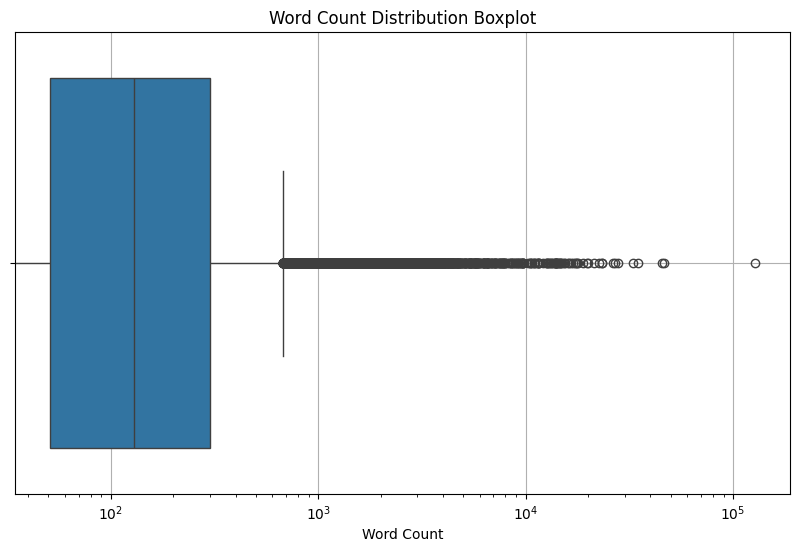

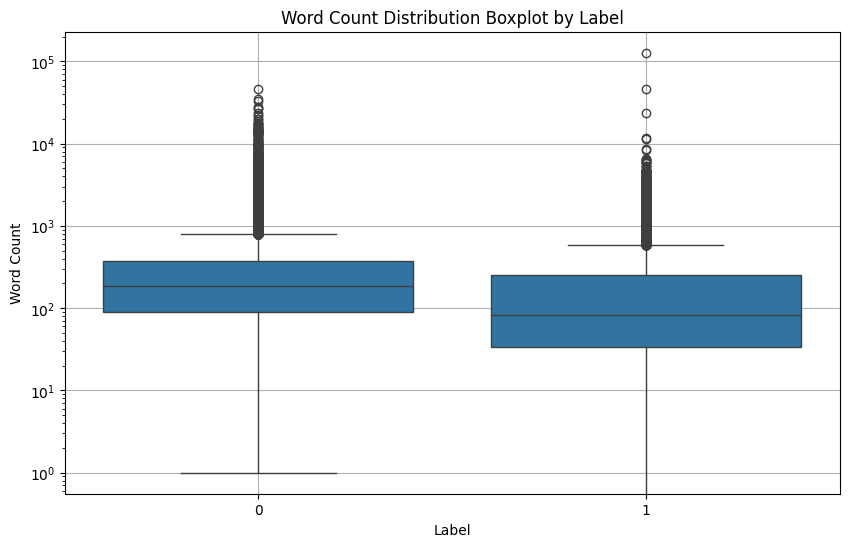

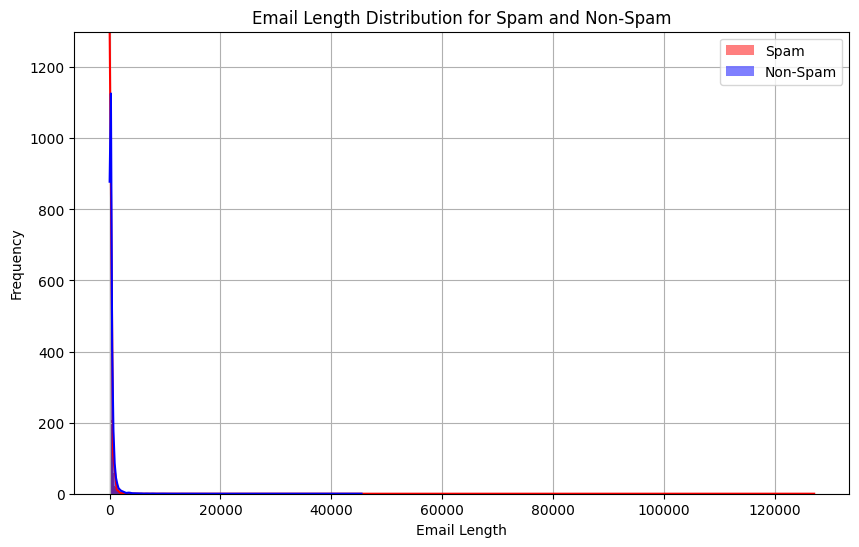

In [29]:
visualizer.plot_word_count_boxplot()
visualizer.plot_word_count_boxplot_by_label()
visualizer.plot_email_length_histogram()

### Additional word count plots:
This bar plot shows the average word count for spam and non-spam emails.
* Non-Spam Emails: Have a higher average word count (~175 words)
* Spam Emails: Have a lower average word count (~100 words).
* Insight: Non-spam emails tend to be longer than spam emails on average.

#### Min and Max Word Count by Label
This bar plot shows the minimum and maximum word count for spam and non-spam emails.
* Non-Spam Emails: Minimum word count is 0 words; maximum word count is around 22,000 words.
* Spam Emails: Minimum word count is around 0 words; maximum word count is around 55,000 words.
* Insight: Both spam and non-spam emails can have very low word counts, but spam emails can also have extremely high word counts, indicating some very lengthy spam emails.

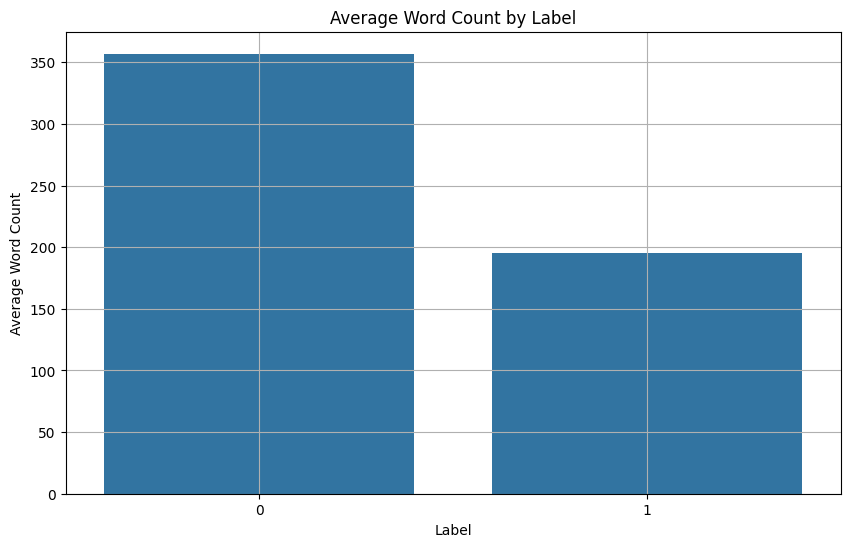

In [30]:
visualizer.plot_avg_word_count_by_label()

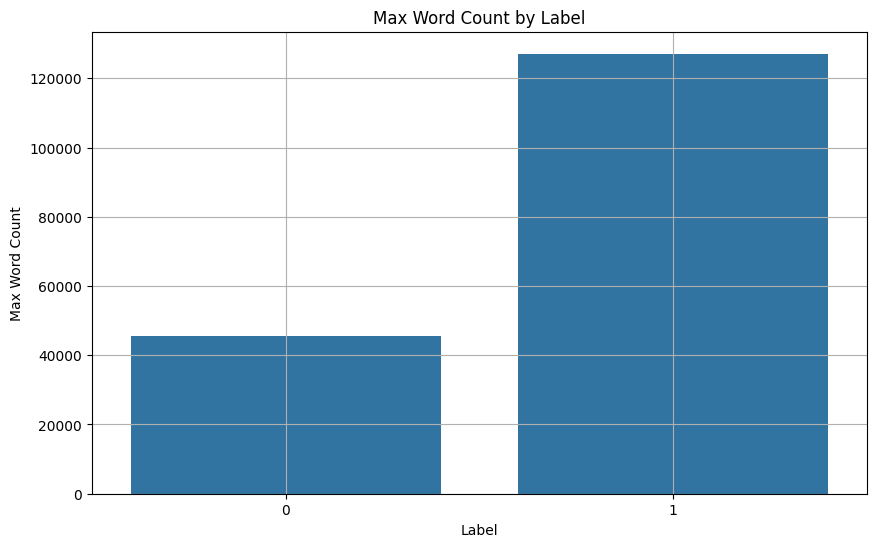

In [31]:
visualizer.plot_max_word_count_by_label()

### word cloud for the common words analysis
These word clouds show the most frequent words in spam and non-spam emails
* Spam Emails: Common words include "top," "news," "daily," "cable," "network," and "videos."
* Non-Spam Emails: Common words include "added," "sender," "submission," "note," "virus," and "total."
* Insight: Spam emails often use words related to news and media, while non-spam emails include terms related to submissions and system notifications.

Word Cloud for Spam Emails


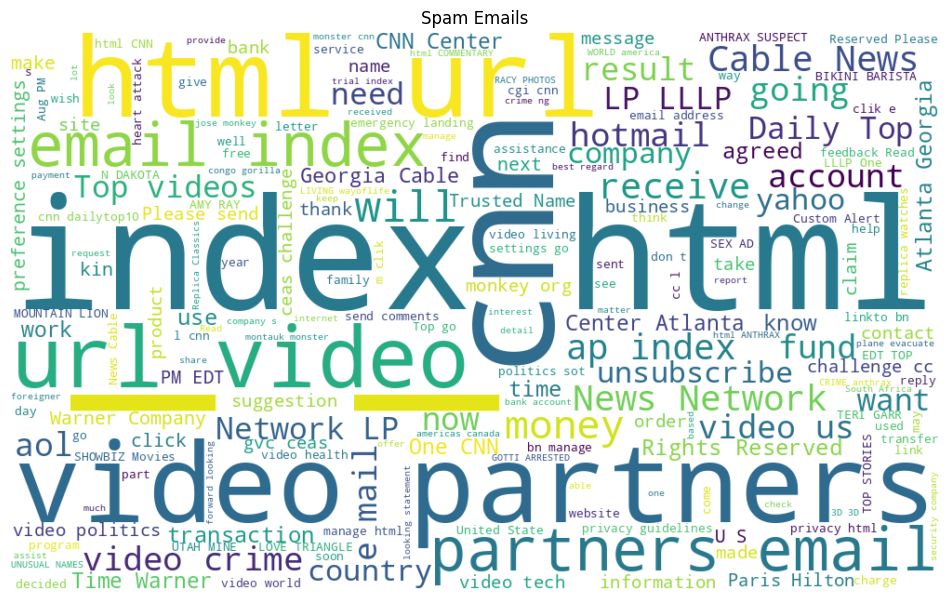

Word Cloud for Non-Spam Emails


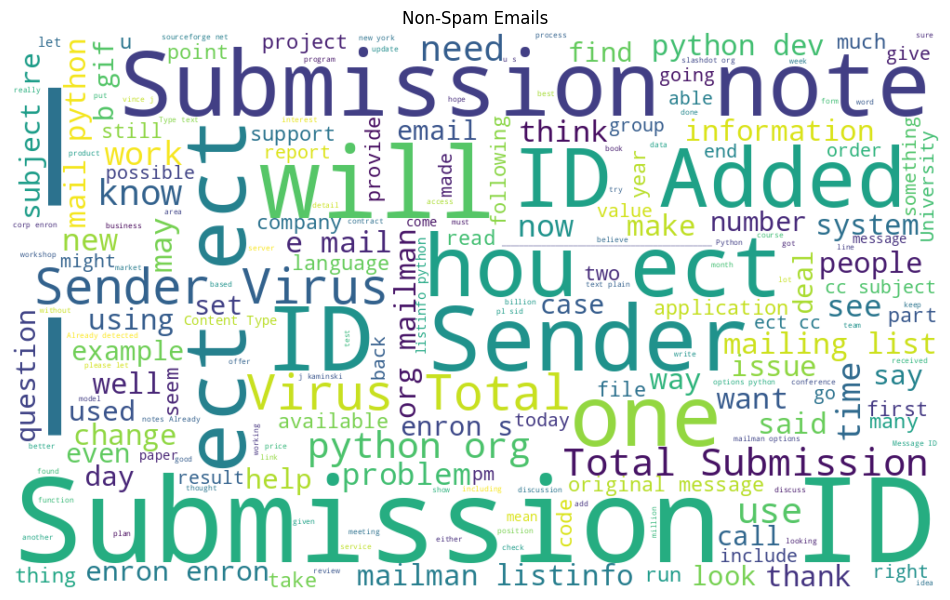

In [32]:
visualizer.plot_word_clouds()

### Character Count Distribution Boxplot by Label
Explanation: Boxplot showing the distribution of character counts for spam and non-spam emails.

Summary: Both spam and non-spam emails have similar character count distributions, with outliers in both categories

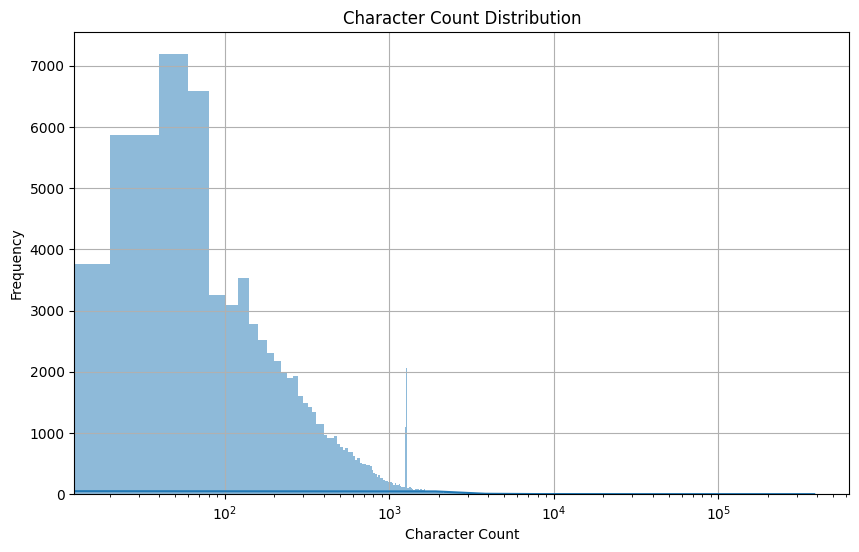

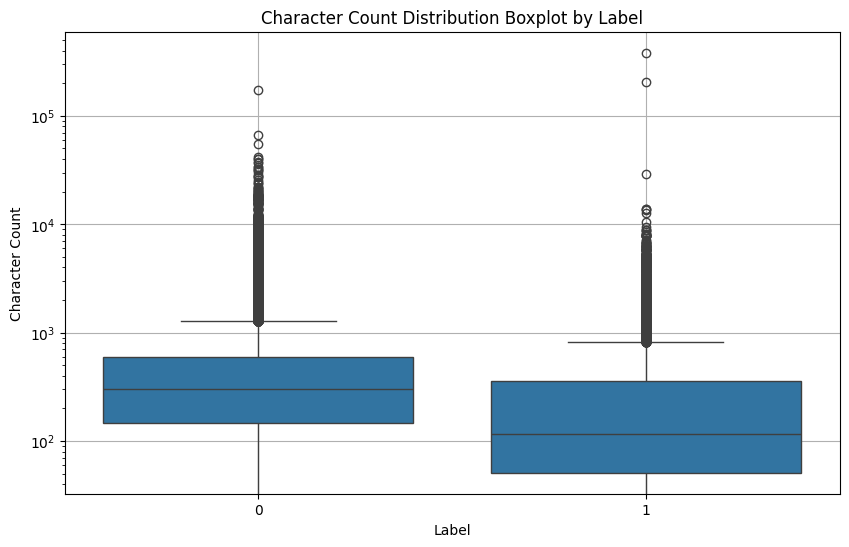

In [33]:
visualizer.plot_char_count_distribution()
visualizer.plot_char_count_boxplot()

### Capital Letter Ratio Distribution
Explanation: Histogram showing the distribution of capital letter ratios in emails.

Summary: Most emails have a low capital letter ratio, with some emails having a higher proportion of capital letters.

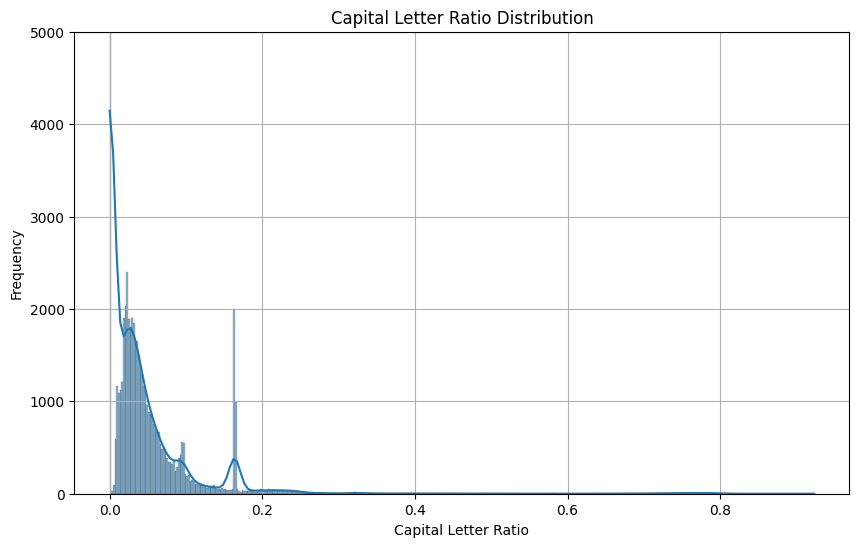

In [34]:
visualizer.plot_capital_ratio_distribution()

### Sentiment Distribution:
Explanation: This histogram shows the distribution of sentiment polarity scores for the emails, ranging from -1 (very negative) to 1 (very positive). Most emails have a neutral or slightly positive sentiment, with a high peak at zero, indicating a neutral sentiment.

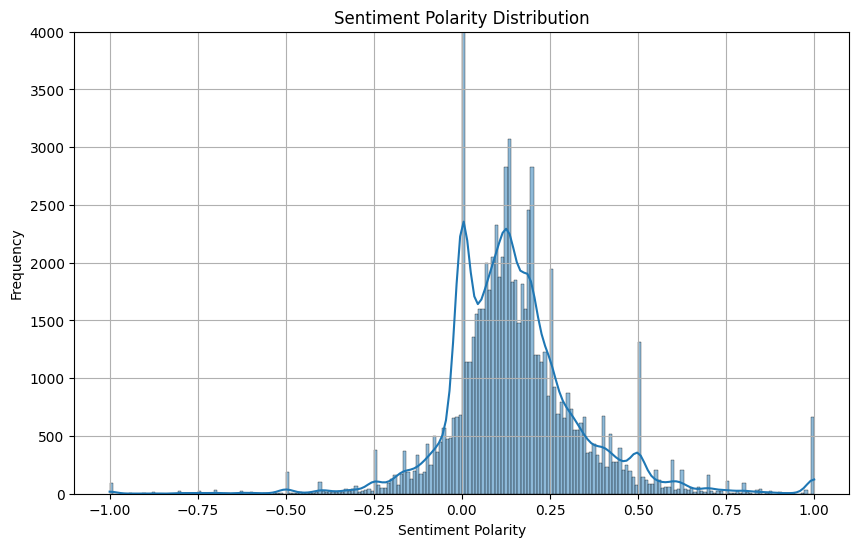

In [35]:
visualizer.plot_sentiment_distribution()

### Correlation Matrix
Explanation: Heatmap showing correlations between numeric features.

Summary: Strong positive correlations between word_count and char_count, and moderate correlations between char_count and capital_count.

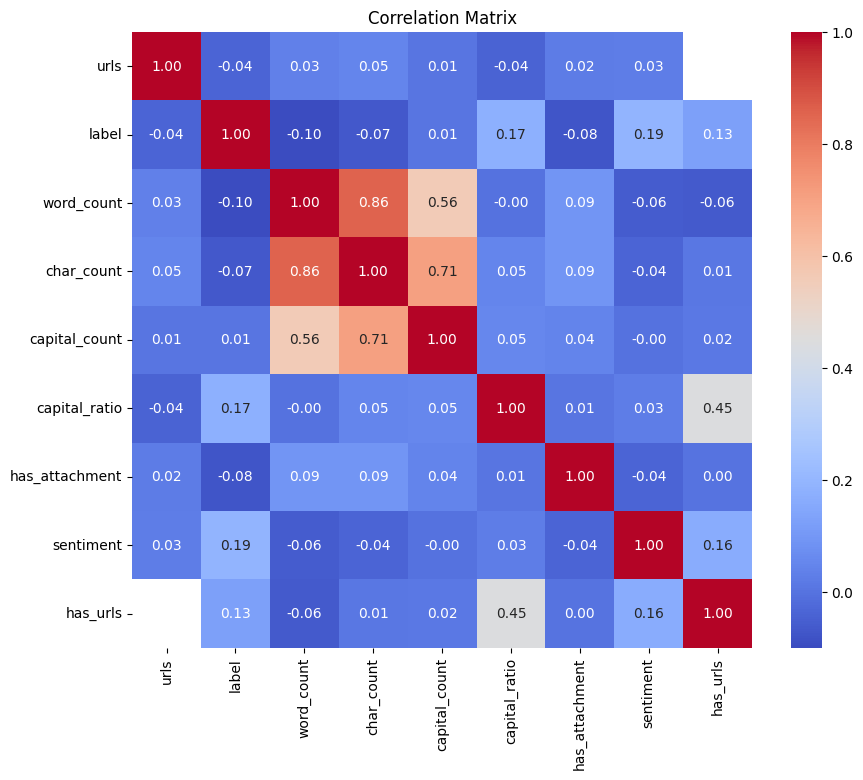

In [36]:
visualizer.plot_correlation_matrix()

### spam rate by different periods
#### Spam Rate by Hour: This line plot shows the spam rate for each hour of the day
* Peaks in spam rate are observed around 10 AM and between 3 PM and 6 PM
* The lowest spam rate is observed around 11 PM.
#### Spam Rate by Week
* The spam rate remains high and consistent for the initial weeks.
* There is a noticeable drop in spam rate around the 25th week.
* A sharp increase in spam rate is observed after the 40th week, returning to near 100%.
#### Spam Rate by Weekday
* The spam rate varies throughout the week.
* The highest spam rate is observed on Friday and thursday.
* The lowest spam rate is observed on Wednesday.
* The spam rate tends to be higher at the beginning and the end of the week.

In [37]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

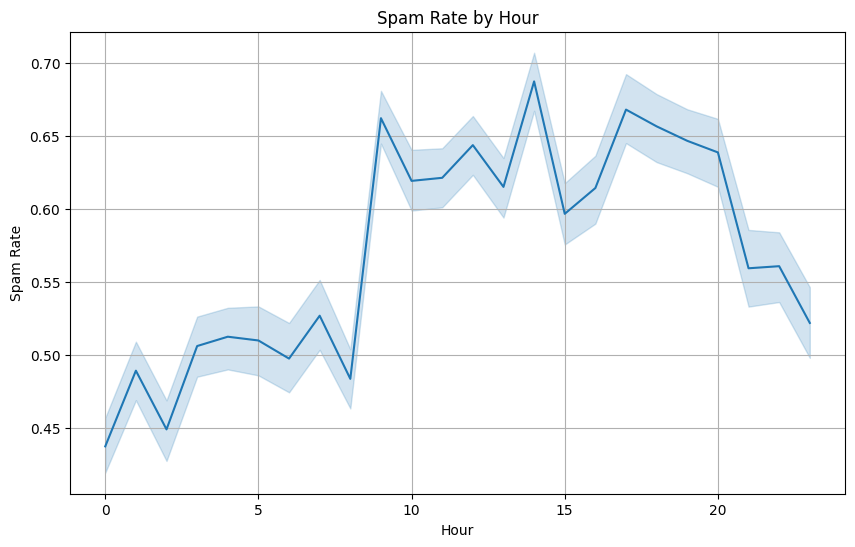

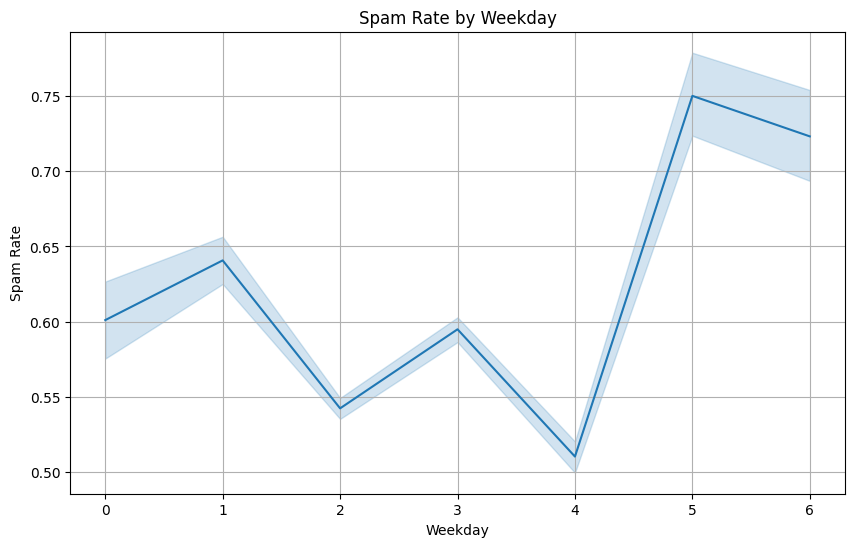

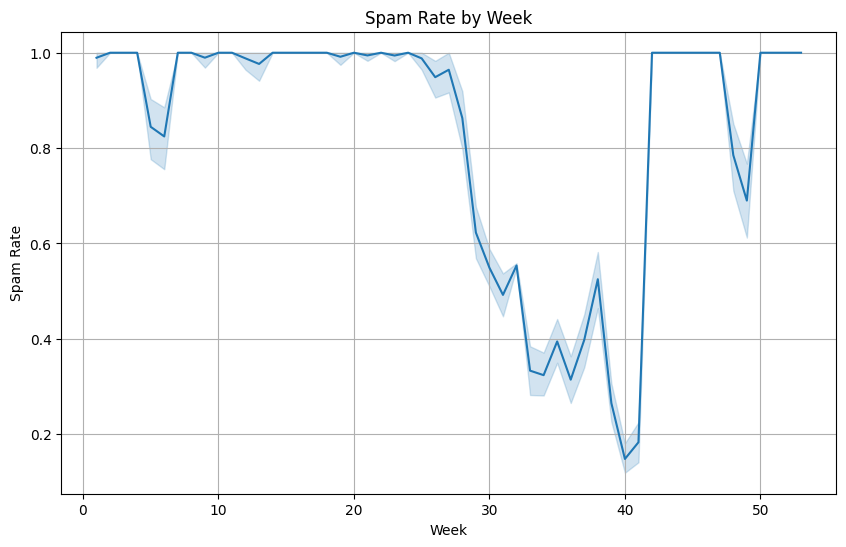

In [38]:
visualizer.plot_spam_rate_by_time(time_feature='hour')
visualizer.plot_spam_rate_by_time(time_feature='weekday')
visualizer.plot_spam_rate_by_time(time_feature='week')

### URL plots

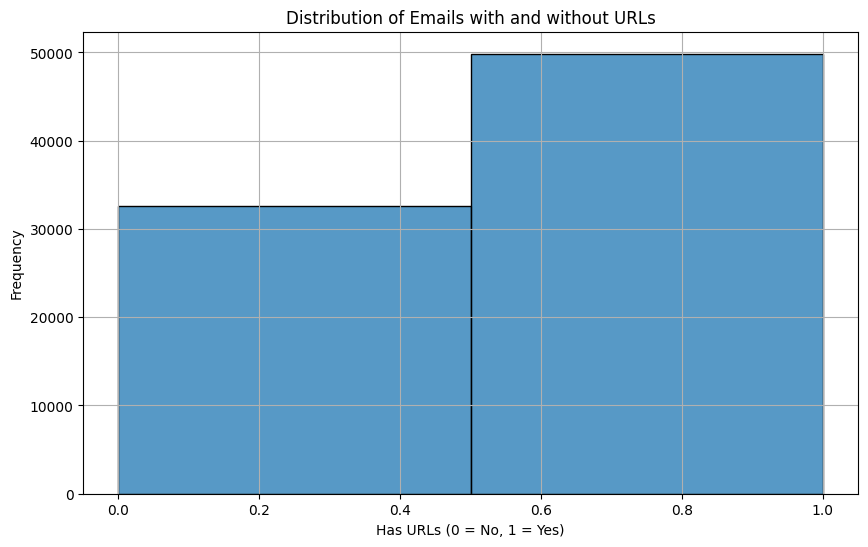

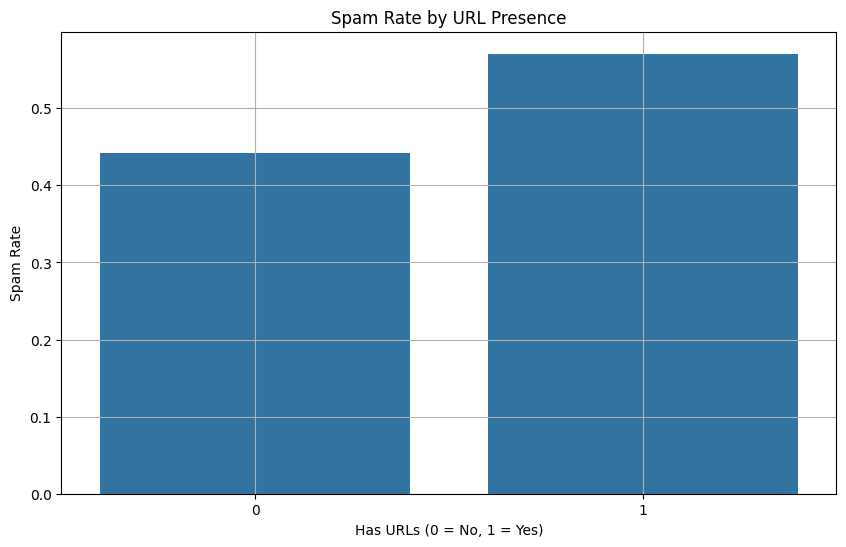

In [39]:
# Perform visualizations for URL analysis
visualizer.plot_url_distribution()
visualizer.plot_spam_rate_by_url()

In [40]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### By Distribution of senders

### MetaData visualizations on senders

In [41]:
# visualizer.plot_spam_rate_by_metadata(column='domain', top_n=10)

### Pickles

In [42]:
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data'
pkl_file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/preprocessed_data.pkl'

In [43]:
# Define the path in Google Drive where you want to save the preprocessed data
analytics.raw_df.to_pickle(pkl_file_path)

# Part B

## Extracting Data from PKL file when crashed
####(after runtime erros)

## 1. Imports

In [1]:
!pip install datasets
!pip install pytorch_lightning
!pip install torch torchvision

In [2]:
# Standard library imports
print("Script started")
import os
import warnings

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for classic machine learning and preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# PyTorch and related utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.quantization
from torch.utils.data import DataLoader, Dataset, TensorDataset

# PyTorch Lightning
import pytorch_lightning as pl
import torchmetrics

# Transformers and Datasets for NLP models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import Dataset

# TensorFlow and Keras for additional deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# XGBoost for gradient boosting
import xgboost as xgb

# Working with Google Colab (if applicable)
from google.colab import drive

import pickle

print("Imports part is finished")

Script started
Imports part is finished


In [3]:
#### Load Data from Local Files
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data'
pkl_file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/preprocessed_data.pkl'
manipulated_wo_body = f'{file_path}/manipulated_wo_body.pkl'
manipulated_only_body = f'{file_path}/manipulated_only_body.pkl'
raw_data = f'{file_path}/raw_data.pkl'

manipulated_wo_body_df = pd.read_pickle(manipulated_wo_body)
manipulated_only_body_df = pd.read_pickle(manipulated_only_body)
raw_data_df = pd.read_pickle(raw_data)

if os.path.exists(pkl_file_path):
    df = pd.read_pickle(pkl_file_path)
    print("Columns available after loading:", df.columns.tolist())
else:
    print("Preprocessed data file not found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns available after loading: ['sender', 'date', 'receiver', 'body', 'subject', 'urls', 'label', 'source', 'word_count', 'char_count', 'capital_count', 'capital_ratio', 'domain', 'has_attachment', 'hour', 'weekday', 'week', 'sentiment', 'has_urls']


In [4]:
#### Save Manipulated DataFrames to Local Files
df[['label', 'body']].to_pickle(manipulated_only_body)
phishing_email_df = pd.read_csv(f'{file_path}/phishing_email.csv')
phishing_email_df.rename(columns={'text_combined': 'body'}, inplace=True)
phishing_email_df.to_pickle(raw_data)

In [5]:
# Display the first few rows of each DataFrame to verify the data
print("No body; ", manipulated_wo_body_df.head())
print("Only Body: ", manipulated_only_body_df.head())
print("Raw" ,raw_data_df.head())


No body;     capital_count  capital_ratio  has_urls  hour  sentiment  week  weekday  \
0              6       0.021978         1  23.0   0.039236  32.0      1.0   
1              1       0.012195         1  23.0   0.000000  32.0      1.0   
2            645       0.164625         1   8.0   0.198214  32.0      2.0   
3            184       0.007535         1  23.0   0.090032  32.0      1.0   
4             36       0.205714         1  23.0   0.000000  32.0      1.0   

   word_count  domain_other_domains  source_Enron  source_Ling  \
0          46                  True         False        False   
1           9                  True         False        False   
2         302                  True         False        False   
3        2660                  True         False        False   
4           2                  True         False        False   

   source_Nazario  source_Nigerian_Fraud  source_SpamAssasin  \
0           False                  False               False   
1 

## 2. Classes

## Classes per Task

#### *Project Summary*

In this project, we developed a comprehensive machine learning pipeline aimed at training and optimizing transformer models, specifically XLNet and RoBERTa. Our pipeline integrates several advanced techniques to ensure robust model performance.

- *Data Preparation:* We designed the DataPreprocessing class to handle all aspects of data preparation. This includes tokenizing text data, saving and loading datasets as TensorDataset objects, and creating DataLoaders for training, validation, and testing. This class ensures that our data is efficiently processed and ready for model training.

- *Model Training and Evaluation:* The ModelTrainer class manages the core training process. It supports applying shrinking methods like pruning, quantization, and weight decay, which help in optimizing model performance and size. Additionally, we implemented knowledge distillation within this class to effectively train smaller student models. This class works closely with DataPreprocessing to utilize the prepared DataLoaders.

- *Model Wrapping:* The TransformerModelWrapper class wraps the transformer models, managing their forward passes, training steps, validation, and testing. This class also handles model saving, logging, and memory management, making the training process more efficient and organized. The model wrapper interacts with ModelTrainer to execute these processes.

- *Pipeline Management:* The TrainingPipelineManager class orchestrates the entire workflow, ensuring that each step is executed in the correct sequence. It coordinates data preparation through the DataPreprocessing class, manages training and evaluation via the ModelTrainer class, and handles model operations through the TransformerModelWrapper class. This class is the backbone of the pipeline, ensuring smooth execution and integration of all components.

### *Flow Between Classes:*
The flow begins with the TrainingPipelineManager, which initiates data preparation through DataPreprocessing. Once the data is ready, TrainingPipelineManager calls on ModelTrainer to train and evaluate the models using the DataLoaders. During training, the ModelTrainer interacts with the TransformerModelWrapper to manage model-specific tasks such as forward passes and saving model states. After the main models are trained, TrainingPipelineManager handles the training of student models through knowledge distillation, again utilizing the coordination between ModelTrainer and TransformerModelWrapper.

Overall, our project is designed to be modular, allowing for flexibility in integrating different models and techniques. The clear flow between classes ensures that each component works together seamlessly, resulting in a robust and adaptable pipeline.

### 2.1 Data Preprocessing

#### Data Preprocessing:
Handles data tokenization, saving/loading of tokenized data, and creation of DataLoaders for training and evaluation.

In [6]:
class DataPreprocessing:
    def __init__(self, data, tokenizer_name_xlnet, tokenizer_name_roberta, test_size=0.4, max_length=128, truncate_length=1000):
        """
        Initialize the DataPreprocessing class with the dataset, tokenizer names, and configuration parameters.
        """
        self.data = data
        self.tokenizers = {
            'xlnet-base-cased': AutoTokenizer.from_pretrained(tokenizer_name_xlnet),
            'roberta-base': AutoTokenizer.from_pretrained(tokenizer_name_roberta)
        }
        self.test_size = test_size
        self.max_length = max_length
        self.truncate_length = truncate_length
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print("DataPreprocessing initialized with:")
        print(f"Test size: {self.test_size}, Max length: {self.max_length}, Truncate length: {self.truncate_length}")
        # print(f"Using device: {self.device}")

    def find_long_texts(self):
        """
        Identify texts in the dataset that exceed the specified truncate length.
        """
        long_texts = [text for text in self.data['body'] if len(text) > self.truncate_length]
        print(f"Found {len(long_texts)} long texts that exceed {self.truncate_length} characters.")
        return long_texts

    def split_data(self):
        """
        Split the data into training and validation sets.
        """
        train_data, val_data = train_test_split(self.data, test_size=self.test_size, random_state=42)
        print(f"Data split into {len(train_data)} training samples and {len(val_data)} validation samples.")
        return train_data, val_data

    def tokenize_data(self, data, model_name, batch_size=32, save_path=None):
        """
        Tokenize the data using the specified tokenizer and create a TensorDataset.
        Optionally save the tokenized data to a .pkl file.
        """
        tokenizer = self.tokenizers[model_name]
        encodings = tokenizer(
            data['body'].tolist(),
            truncation=True, # Truncating if too long
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        dataset = TensorDataset(
            encodings['input_ids'], encodings['attention_mask'], torch.tensor(data['label'].values)
        )

        print(f"Dataset type before saving: {type(dataset)}")  #line

        # Save the TensorDataset directly
        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(dataset, f)
            print(f"Tokenized data saved to {save_path}")

        return dataset  # Return the TensorDataset, (instead ofh DataLoader)

    def load_tokenized_data(self, load_path):
        """
        Load tokenized data from a .pkl file.
        """
        with open(load_path, 'rb') as f:
            dataset = pickle.load(f)
        print(f"Loaded data type: {type(dataset)}, length: {len(dataset)}")
        return dataset

    def prepare_data(self, model_name):
        """
        Prepare the data by splitting, tokenizing, and creating DataLoaders.
        If the tokenized data .pkl file exists, load it. Otherwise, run the tokenizers and save the data.
        """
        tokenized_data_path = f'{model_name}_tokenized_data.pkl'

        if os.path.exists(tokenized_data_path):
            print(f"Loading tokenized data from {tokenized_data_path}...")
            dataset = self.load_tokenized_data(tokenized_data_path)
            print(f"Loaded dataset type: {type(dataset)}, length: {len(dataset)}")

            # Ensure the dataset is not a DataLoader
            if isinstance(dataset, DataLoader):
                raise ValueError(f"Expected TensorDataset but got DataLoader in {tokenized_data_path}")

            # Split the loaded TensorDataset into train, validation, and test sets
            train_size = int((1-self.test_size) * len(dataset)) # modify to generic
            val_size = int((self.test_size/2) * len(dataset))
            test_size = len(dataset) - train_size - val_size

            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size, test_size])

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

            return train_loader, val_loader, test_loader

        else:
            print("Tokenized data file not found. Running tokenization...")
            dataset = self.tokenize_data(self.data, model_name, save_path=tokenized_data_path)
            print(f"Dataset type after tokenization: {type(dataset)}")

            train_size = int((1-self.test_size) * len(dataset))
            val_size = int((self.test_size/2) * len(dataset))
            test_size = len(dataset) - train_size - val_size

            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size, test_size])

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

            return train_loader, val_loader, test_loader


#### Class: ModelTrainer
Manages model training, evaluation, and application of shrinking methods, including knowledge distillation.

In [7]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, shrinking_method=None):
        """
        Initialize the ModelTrainer with the model, DataLoaders, and the desired shrinking method.
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.shrinking_method = shrinking_method
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)

        print(f"ModelTrainer initialized with {shrinking_method} shrinking method.")

    def train_model(self, epochs=5):
        """
        Train the model for a specified number of epochs. Apply the shrinking method if specified.
        """
        if self.shrinking_method:
            self.apply_shrinking(self.shrinking_method)

        for epoch in range(epochs):
            self.model.train() # training mode
            epoch_loss = 0
            for batch_idx, batch in enumerate(self.train_loader):
                loss = self.model.training_step(batch, batch_idx)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                if batch_idx % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
            print(f"Epoch {epoch+1} completed with average loss: {epoch_loss / len(self.train_loader):.4f}")
        self.model.on_train_end()

    def evaluate_model(self, loader):
        """
        Evaluate the model on a specified DataLoader.
        """
        self.model.eval()
        results = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(loader):
                results.append(self.model.validation_step(batch, batch_idx))
            metrics = self.model.validation_epoch_end(results)
            print(f"Evaluation complete. Metrics: {metrics}")
        # self.model.on_validation_end()
        return metrics

    def apply_shrinking(self, method):
        """
        Apply the selected shrinking method (prune, quantize, weight decay, or distillation).
        """
        if method == 'prune':
            self.prune_model()
        elif method == 'quantize':
            self.quantize_model()
        elif method == 'weight_decay':
            self.apply_weight_decay()
        elif method == 'distillation':
            pass  # Distillation will be handled separately in the student training phase

        print(f"{method} method applied.")

    def prune_model(self, amount=0.2):
        """
        Apply pruning to the model to reduce the number of parameters.
        """
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=amount)
                print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")

    def quantize_model(self):
        """
        Apply quantization to the model to reduce memory usage and increase inference speed.
        """
        self.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.quantization.prepare(self.model, inplace=True)
        torch.quantization.convert(self.model, inplace=True)
        print("Model quantized.")

    def apply_weight_decay(self, weight_decay=1e-5):
        """
        Apply weight decay to the model parameters as a form of regularization.
        """
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                param.data = param.data - weight_decay * param.data
                print(f"Applied weight decay to {name}: {weight_decay}")

    def train_student(self, teacher_model, student_model, train_loader, epochs=8):
            """
            Train the student model using knowledge distillation from the teacher model.
            """
            optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-5)
            student_wrapper = TransformerModelWrapper(model_name=None, custom_model=student_model)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            for epoch in range(epochs):
                student_wrapper.train()
                teacher_model.eval()
                epoch_loss = 0

                for batch_idx, batch in enumerate(train_loader):
                    input_ids, attention_mask, labels = batch
                    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                    with torch.no_grad():
                        teacher_output = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

                    student_output = student_wrapper(input_ids=input_ids)
                    loss = self.distillation_loss(student_output, teacher_output)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()

                    if batch_idx % 10 == 0:
                        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
                print(f"Epoch {epoch+1} completed with average distillation loss: {epoch_loss / len(train_loader):.4f}")

    def distillation_loss(self, student_output, teacher_output, temperature=2.0):
        """
        Compute the distillation loss between the student and teacher model outputs.
        """
        return nn.KLDivLoss()(F.log_softmax(student_output / temperature, dim=1),
                              F.softmax(teacher_output / temperature, dim=1))


#### Class: TransformerModelWrapper
Wraps transformer models, managing forward passes, training steps, validation, and testing.

In [8]:
class TransformerModelWrapper(pl.LightningModule):
    def __init__(self, model_name, num_labels=2, custom_model=None):
        """
        Initialize the TransformerModelWrapper with a pre-trained model or a custom model.
        """
        super(TransformerModelWrapper, self).__init__()
        # Check if 'device' is already defined. If not, define it.
        if not hasattr(self, 'device'):
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if custom_model:
            self.model = custom_model
        else:
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels).to(self.device)
        self.dropout = nn.Dropout(0.3)
        self.roc_auc_metric = torchmetrics.AUROC(task='binary', num_classes=num_labels)

        print(f"Initialized TransformerModelWrapper with model: {model_name}")
        print(f"Using device: {self.device}")

    def forward(self, input_ids, attention_mask, labels=None):
        """
        Forward pass for the model.
        """
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = self.dropout(outputs.logits)

        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return loss, logits
        else:
            return logits

    def step(self, batch, batch_idx, stage):
        """
        Perform a step during training, validation, or testing.
        """
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)
        loss, logits = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate metrics
        preds = torch.argmax(logits, dim=1)
        roc_auc = self.roc_auc_metric(preds, labels)
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        accuracy = accuracy_score(labels.cpu(), preds.cpu())

        # Log metrics
        self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_roc_auc', roc_auc, on_step=True, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)

        print(f"{stage.capitalize()} Step - Batch {batch_idx}, Loss: {loss.item():.4f}, ROC AUC: {roc_auc.item():.4f}, F1: {f1.item():.4f}, ACC: {accuracy.item():.4f}")

        return loss

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.
        """
        return self.step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.
        """
        return self.step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        """
        Perform a single test step.
        """
        return self.step(batch, batch_idx, 'test')

    def validation_epoch_end(self, outputs):
        """
        Aggregate validation results at the end of the epoch.
        """
        avg_loss = torch.stack([x for x in outputs]).mean()
        self.log('val_loss', avg_loss, prog_bar=True)
        print(f"Validation epoch end - Average Loss: {avg_loss:.4f}")
        return avg_loss

    def configure_optimizers(self):
        """
        Configure optimizers for training.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer

    def on_train_end(self):
        """
        Actions to perform at the end of training, such as saving the model, logging metrics, and clearing CUDA cache.
        """
        # Save the model
        model_path = "model_final.pth"
        torch.save(self.model.state_dict(), model_path)
        print(f"Model saved as {model_path}")

        # Log the final metrics to a file
        metrics_path = "training_metrics.txt"
        with open(metrics_path, "w") as f:
            f.write(str(self.trainer.callback_metrics))
        print(f"Final training metrics saved to {metrics_path}")

        # Generate and save training loss plot
        epochs = range(len(self.trainer.callback_metrics['train_loss']))
        plt.plot(epochs, self.trainer.callback_metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.trainer.callback_metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("training_loss_plot.png")
        plt.close()
        print("Training loss plot saved as training_loss_plot.png")

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
        print("Training complete.")

        gc.collect()
        print("clear unneccarry cache cleared.")


    def on_validation_end(self):
        """
        Actions to perform at the end of validation, such as logging final validation metrics and clearing CUDA cache.
        """
        print("Validation complete.")
        val_metrics = self.trainer.callback_metrics
        metrics_path = "validation_metrics.txt"
        with open(metrics_path, "w") as f:
            f.write(str(val_metrics))
        print(f"Final Validation Metrics: Loss: {val_metrics['val_loss']:.4f}, ROC AUC: {val_metrics['val_roc_auc']:.4f}")
        print(f"Validation metrics saved to {metrics_path}")

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")

    def on_test_end(self):
        """
        Actions to perform at the end of testing, such as logging final test metrics and clearing CUDA cache.
        """
        print("Testing complete.")
        test_metrics = self.trainer.callback_metrics
        metrics_path = "test_metrics.txt"
        with open(metrics_path, "w") as f:
            f.write(str(test_metrics))
        print(f"Final Test Metrics: Loss: {test_metrics['test_loss']:.4f}, ROC AUC: {test_metrics['test_roc_auc']:.4f}")
        print(f"Test metrics saved to {metrics_path}")

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")


#### Class: StudentModel
Implement the student-teacher shrinking method

In [9]:
class StudentModel(nn.Module):
    def __init__(self, input_dim, num_labels):
        """
        Initialize the StudentModel with a simple architecture.
        """
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)  # First fully connected layer
        self.fc2 = nn.Linear(50, num_labels)  # Output layer
        self.dropout = nn.Dropout(0.3)  # Add dropout for regularization

        print(f"Initialized StudentModel with input dimension {input_dim} and output classes {num_labels}")

    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass for the student model.
        """
        x = torch.relu(self.fc1(input_ids))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits


#### Class: TrainingPipelineManager
Orchestrates the entire training pipeline, including data preparation, model training, evaluation, and student model training.

In [10]:
class TrainingPipelineManager:
    def __init__(self, data, model_name_xlnet, model_name_roberta):
        """
        Initialize the TrainingPipelineManager with the dataset and model names.
        """
        self.data = data
        self.data_manager = DataPreprocessing(data, model_name_xlnet, model_name_roberta)
        self.train_loader_xlnet, self.val_loader_xlnet, self.test_loader_xlnet = self.data_manager.prepare_data(model_name_xlnet)
        self.train_loader_roberta, self.val_loader_roberta, self.test_loader_roberta = self.data_manager.prepare_data(model_name_roberta)
        self.metrics_df = pd.DataFrame()

        print(f"TrainingPipelineManager initialized with XLNet and RoBERTa models.")

    def train_and_evaluate(self):
        """
        Train and evaluate the models, applying different shrinking methods.
        """
        shrinking_methods = ['prune', 'quantize', 'weight_decay', 'distillation']
        for method in shrinking_methods:
            print(f"Applying {method} method.")
            # Train and evaluate XLNet
            self._train_and_evaluate_model('xlnet-base-cased', self.train_loader_xlnet, self.val_loader_xlnet, method)

            # Train and evaluate RoBERTa
            self._train_and_evaluate_model('roberta-base', self.train_loader_roberta, self.val_loader_roberta, method)

    def _train_and_evaluate_model(self, model_name, train_loader, val_loader, shrinking_method):
        """
        Internal method to train and evaluate a model with a given shrinking method.
        """
        # Initialize model and trainer
        model_wrapper = TransformerModelWrapper(model_name=model_name)
        trainer = ModelTrainer(model=model_wrapper, train_loader=train_loader, val_loader=val_loader, shrinking_method=shrinking_method)

        # Train the model
        trainer.train_model()

        # Evaluate the model
        metrics = trainer.evaluate_model(val_loader)
        print(f"Results for {model_name} with {shrinking_method}: {metrics}")
        self.metrics_df = self.log_metrics(model_name, shrinking_method, metrics)


    def log_metrics(self, model_name, method, metrics):
        """
        Log metrics for a specific model and shrinking method.
        """
        metrics_entry = {
            'model': model_name,
            'method': method,
            'val_loss': metrics['val_loss'],
            'val_roc_auc': metrics['val_roc_auc'],
            'val_f1_score': metrics['val_f1'],
            'val_accuracy': metrics['val_acc']
        }
        self.metrics_df = self.metrics_df.append(metrics_entry, ignore_index=True)
        print(f"Metrics logged for {model_name} with {method}.")
        return self.metrics_df

    def train_student_model(self):
        """
        Train and evaluate the student model using distillation.
        """
        print("Training student model with distillation.")

        # Initialize teacher models
        teacher_model_xlnet = TransformerModelWrapper(model_name='xlnet-base-cased')
        teacher_model_roberta = TransformerModelWrapper(model_name='roberta-base')

        # Initialize student models
        input_dim = self.train_loader_xlnet.dataset.tensors[0].shape[1]
        student_model_xlnet = StudentModel(input_dim=input_dim, num_labels=2).to(self.device)
        student_model_roberta = StudentModel(input_dim=input_dim, num_labels=2).to(self.device)

        # Initialize ModelTrainer
        trainer = ModelTrainer(model=None, train_loader=None, val_loader=None)  # Initialize without specific models/loaders

        # Train student models with distillation
        trainer.train_student(teacher_model_xlnet, student_model_xlnet, self.train_loader_xlnet)
        trainer.train_student(teacher_model_roberta, student_model_roberta, self.train_loader_roberta)

        # Evaluate student models
        student_wrapper_xlnet = TransformerModelWrapper(model_name=None, custom_model=student_model_xlnet)
        student_metrics_xlnet = trainer.evaluate_model(self.val_loader_xlnet)

        student_wrapper_roberta = TransformerModelWrapper(model_name=None, custom_model=student_model_roberta)
        student_metrics_roberta = trainer.evaluate_model(self.val_loader_roberta)

        print(f"Results for XLNet Student: {student_metrics_xlnet}")
        print(f"Results for RoBERTa Student: {student_metrics_roberta}")

    def execute_pipeline(self):
        """
        Execute the entire training pipeline.
        """
        print("Starting training and evaluation for all models.")
        self.train_and_evaluate()
        self.train_student_model()
        print("Training pipeline execution complete.")


## Running project

In [14]:
# # To delete previous pkls:

# # Define the file paths
# xlnet_tokenized_data_path = 'xlnet-base-cased_tokenized_data.pkl'
# roberta_tokenized_data_path = 'roberta-base_tokenized_data.pkl'

# # Delete existing .pkl files if they exist
# if os.path.exists(xlnet_tokenized_data_path):
#     os.remove(xlnet_tokenized_data_path)
#     print(f"Deleted old {xlnet_tokenized_data_path}")

# if os.path.exists(roberta_tokenized_data_path):
#     os.remove(roberta_tokenized_data_path)
#     print(f"Deleted old {roberta_tokenized_data_path}")


In [11]:
# Step 1: Initialize the pipeline with manipulated text data
project_manipulated = TrainingPipelineManager(
    data=manipulated_only_body_df,
    model_name_xlnet='xlnet-base-cased',
    model_name_roberta='roberta-base'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DataPreprocessing initialized with:
Test size: 0.4, Max length: 128, Truncate length: 1000
Loading tokenized data from xlnet-base-cased_tokenized_data.pkl...


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loaded data type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loaded dataset type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loading tokenized data from roberta-base_tokenized_data.pkl...
Loaded data type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loaded dataset type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
TrainingPipelineManager initialized with XLNet and RoBERTa models.


In [16]:
# # Tokenize and save the data as TensorDataset
# train_loader_xlnet, val_loader_xlnet, test_loader_xlnet = project_manipulated.data_manager.prepare_data('xlnet-base-cased')
# train_loader_roberta, val_loader_roberta, test_loader_roberta = project_manipulated.data_manager.prepare_data('roberta-base')


In [17]:
# # Verify the XLNet saved TensorDataset
# dataset_xlnet = project_manipulated.data_manager.load_tokenized_data('xlnet-base-cased_tokenized_data.pkl')
# print(f"XLNet Loaded dataset type: {type(dataset_xlnet)}, length: {len(dataset_xlnet)}")

# # Verify the RoBERTa saved TensorDataset
# dataset_roberta = project_manipulated.data_manager.load_tokenized_data('roberta-base_tokenized_data.pkl')
# print(f"RoBERTa Loaded dataset type: {type(dataset_roberta)}, length: {len(dataset_roberta)}")


In [ ]:
# Run the pipeline using the loaded or newly prepared data
project_manipulated.execute_pipeline()

Starting training and evaluation for all models.
Applying prune method.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: xlnet-base-cased
Using device: cpu
ModelTrainer initialized with prune shrinking method.
Sparsity in model.transformer.layer.0.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.0.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.1.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.1.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.2.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.2.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.3.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.3.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.4.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.4.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.5.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.5.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.6.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.l

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 0, Loss: 0.6422, ROC AUC: 0.4167, F1: 0.5273, ACC: 0.5000
Epoch 1/5, Batch 0, Loss: 0.6422


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 1, Loss: 0.6908, ROC AUC: 0.5833, F1: 0.6455, ACC: 0.6250


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 2, Loss: 0.8198, ROC AUC: 0.4127, F1: 0.3125, ACC: 0.3750


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 3, Loss: 0.6366, ROC AUC: 0.3333, F1: 0.5000, ACC: 0.5000


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 4, Loss: 0.7359, ROC AUC: 0.6500, F1: 0.5253, ACC: 0.5625


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 5, Loss: 0.6606, ROC AUC: 0.6727, F1: 0.6369, ACC: 0.6250


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 6, Loss: 0.5545, ROC AUC: 0.7091, F1: 0.7500, ACC: 0.7500


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train Step - Batch 7, Loss: 0.4770, ROC AUC: 0.8750, F1: 0.8247, ACC: 0.8125


## Now to run again the main but for "Raw_data"

In [ ]:
raw_data

In [ ]:
# # If you also want to run with regular text data, initialize another instance
# project_regular = TrainingPipelineManager(
#     data=raw_data,  # Assuming you have a DataFrame named `regular_text_df`
#     model_name_xlnet='xlnet-base-cased',
#     model_name_roberta='roberta-base'
# )

In [ ]:
## OPTION 1
# Train and evaluate models on regular text (optional)
project_regular.execute_pipeline()

# View the metrics for regular text
print(project_regular.metrics_df)

## OPTION 2
# # Train and evaluate models on manipulated text
# project_manipulated.execute_pipeline()

# # View the metrics for manipulated text
# print(project_manipulated.metrics_df)

In [ ]:
# Combine metrics for comparison (assuming you ran both pipelines)
# View metrics for manipulated text
# print(project_manipulated.metrics_df)

# (Optional) View metrics for regular text
print(project_regular.metrics_df)

# all_metrics_df = pd.concat([project_manipulated.metrics_df, project_regular.metrics_df])
# print(all_metrics_df)

# # Save combined metrics to a CSV file (optional)
# all_metrics_df.to_csv("combined_metrics.csv", index=False)

In [ ]:
# # Example to view metrics
# print(trainer_xlnet.metrics_df)
# print(trainer_roberta.metrics_df)

# # Combine for comparison
# all_metrics_df = pd.concat([trainer_xlnet.metrics_df, trainer_roberta.metrics_df])
# print(all_metrics_df)

## OLD CODE

In [ ]:
# class DataPreprocessing:
#     def __init__(self, data, tokenizer_name_xlnet, tokenizer_name_roberta, test_size=0.4, max_length=128, truncate_length=1000):
#         self.data = data
#         self.tokenizer_xlnet = AutoTokenizer.from_pretrained(tokenizer_name_xlnet)
#         print(f"Initialized XLNet tokenizer: {self.tokenizer_xlnet}")
#         self.tokenizer_roberta = AutoTokenizer.from_pretrained(tokenizer_name_roberta)
#         print(f"Initialized RoBERTa tokenizer: {self.tokenizer_roberta}")
#         self.test_size = test_size
#         self.max_length = max_length
#         self.truncate_length = truncate_length
#         print("Data Manager initialized")

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         print(f"Using device: {self.device}")

#         # Check for unusually long texts
#         print(f"Maximum length of texts: {max(len(text) for text in self.data['body'])}")
#         print(f"Average length of texts: {sum(len(text) for text in self.data['body']) / len(self.data['body'])}")

#         long_texts = self.find_long_texts(self.data['body'])
#         print(f"Number of texts longer than 10,000 characters: {len(long_texts)}")
#         for text in long_texts[:5]:  # Print first 5 long texts for inspection
#             print(f"Long text ({len(text)} characters): {text[:100]}...")

#     def find_long_texts(self, data, threshold=10000):
#         long_texts = [text for text in data if len(text) > threshold]
#         return long_texts

#     def split_data(self, test_size=0.4):
#         # Splitting DataFrame into train and test sets
#         print(f"Initial shape of df: {self.data.shape}")
#         train_df, test_df = train_test_split(self.data, test_size=test_size, random_state=42)
#         test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

#         print(f"Shape of train_df after split: {train_df.shape}")
#         print(f"Shape of val_df after split: {val_df.shape}")
#         print(f"Shape of test_df after split: {test_df.shape}")
#         return train_df, val_df, test_df

#     def truncate_text(self, text):
#         if len(text) > self.truncate_length:
#             return text[:self.truncate_length]
#         return text

#     def batch_tokenize_data(self, data, tokenizer, batch_size=1000):
#         input_ids = []
#         attention_masks = []

#         print("Batch tokenizing data...")
#         for i in range(0, len(data), batch_size):
#             batch_texts = [self.truncate_text(text) for text in data['body'][i:i+batch_size]]
#             print(f"Tokenizing batch {i//batch_size + 1}/{(len(data) + batch_size - 1) // batch_size}")
#             try:
#                 encoded = tokenizer.batch_encode_plus(
#                     batch_texts,
#                     add_special_tokens=True,
#                     max_length=self.max_length,
#                     padding='max_length',
#                     return_attention_mask=True,
#                     return_tensors='pt',
#                     truncation=True
#                 )
#                 input_ids.append(encoded['input_ids'])
#                 attention_masks.append(encoded['attention_mask'])
#             except Exception as e:
#                 print(f"Error tokenizing batch {i//batch_size + 1}: {e}")
#                 continue  # Skip the problematic batch

#         print("Batch tokenization complete.")
#         return torch.cat(input_ids, dim=0).to(self.device), torch.cat(attention_masks, dim=0).to(self.device)

#     def prepare_data(self, model_name):
#         train_data, val_data, test_data = self.split_data()

#         # Convert labels to tensors
#         print("Converting labels to tensors...")
#         train_labels = torch.tensor(train_data['label'].astype(int).values).to(self.device)
#         val_labels = torch.tensor(val_data['label'].astype(int).values).to(self.device)
#         test_labels = torch.tensor(test_data['label'].astype(int).values).to(self.device)
#         print("Labels conversion complete.")

#         if model_name == 'xlnet-base-cased':
#           # Tokenize data for XLNet
#           print("Batch tokenizing training data with XLNet tokenizer...")
#           train_input_ids_xlnet, train_attention_masks_xlnet = self.batch_tokenize_data(train_data, self.tokenizer_xlnet)
#           print("Batch tokenizing val data with XLNet tokenizer...")
#           val_input_ids_xlnet, val_attention_masks_xlnet = self.batch_tokenize_data(val_data, self.tokenizer_xlnet)
#           print("Batch tokenizing test data with XLNet tokenizer...")
#           test_input_ids_xlnet, test_attention_masks_xlnet = self.batch_tokenize_data(test_data, self.tokenizer_xlnet)

#           # Create DataLoader for XLNet
#           print("Creating DataLoader for XLNet...")
#           train_loader_xlnet = DataLoader(TensorDataset(train_input_ids_xlnet, train_attention_masks_xlnet, train_labels), batch_size=16, shuffle=True)
#           val_loader_xlnet = DataLoader(TensorDataset(val_input_ids_xlnet, val_attention_masks_xlnet, val_labels), batch_size=16, shuffle=False)
#           test_loader_xlnet = DataLoader(TensorDataset(test_input_ids_xlnet, test_attention_masks_xlnet, test_labels), batch_size=16, shuffle=False)

#           print("Data preparation complete.")
#           return train_loader_xlnet, val_loader_xlnet, test_loader_xlnet

#         elif model_name == 'roberta-base':

#           # Tokenize data for RoBERTa
#           print("Batch tokenizing training data with RoBERTa tokenizer...")
#           train_input_ids_roberta, train_attention_masks_roberta = self.batch_tokenize_data(train_data, self.tokenizer_roberta)
#           print("Batch tokenizing val data with RoBERTa tokenizer...")
#           val_input_ids_roberta, val_attention_masks_roberta = self.batch_tokenize_data(val_data, self.tokenizer_roberta)
#           print("Batch tokenizing test data with RoBERTa tokenizer...")
#           test_input_ids_roberta, test_attention_masks_roberta = self.batch_tokenize_data(test_data, self.tokenizer_roberta)

#           # Create DataLoader for RoBERTa
#           print("Creating DataLoader for RoBERTa...")
#           train_loader_roberta = DataLoader(TensorDataset(train_input_ids_roberta, train_attention_masks_roberta, train_labels), batch_size=16, shuffle=True)
#           val_loader_roberta = DataLoader(TensorDataset(val_input_ids_roberta, val_attention_masks_roberta, val_labels), batch_size=16, shuffle=False)
#           test_loader_roberta = DataLoader(TensorDataset(test_input_ids_roberta, test_attention_masks_roberta, test_labels), batch_size=16, shuffle=False)

#           print("Data preparation complete.")
#           return train_loader_roberta,val_loader_roberta, test_loader_roberta

#         else:
#           print('The model is not suppoerted in this script')

### 2.4 Training Pipeline Manager
 Orchestrates the entire training process, coordinating data preparation, model training, and evaluation steps


In [ ]:
# class TrainingPipelineManager(pl.LightningModule):
#   def __init__(self, data, model):
#     super().__init__()
#     self.model = model
#     self.data = data
#     self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     self.data_manager = DataPreprocessing(data, "xlnet-base-cased", "roberta-base")
#     self.train_loader, self.val_loader, self.test_loader = self.data_manager.prepare_data(model)
#     self.roc_auc_scores = []
#     self.losses = []
#     self.acc = []
#     self.precision = []
#     self.f1 = []

#   def forward(self, *args, **kwargs):
#     return self.model(*args, **kwargs)

#   def training_step(self, batch, batch_idx):
#     input_ids, attention_mask, labels = batch
#     outputs = self.model(input_ids, attention_mask, labels=labels)
#     loss = outputs.loss
#     self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#     return loss

#   def training_epoch_end(self, outputs):
#     avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
#     self.losses.append(avg_loss.item())

#   def validation_step(self, batch, batch_idx):
#     input_ids, attention_mask, labels = batch
#     outputs = self.model(input_ids, attention_mask, labels=labels)
#     logits = outputs.logits
#     loss = outputs.loss
#     preds = torch.argmax(logits, dim=1)
#     self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

#     return {'loss': loss, 'preds': preds, 'labels': labels}

#   def validation_epoch_end(self, outputs):
#     preds = torch.cat([x['preds'] for x in outputs], dim=0).cpu()
#     labels = torch.cat([x['labels'] for x in outputs], dim=0).cpu()

#     acc = accuracy_score(labels, preds)
#     precision = precision_score(labels, preds, average='weighted')
#     f1 = f1_score(labels, preds, average='weighted')

#     self.acc.append(acc)
#     self.precision.append(precision)
#     self.f1.append(f1)

#     self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
#     self.log('val_precision', precision, on_step=False, on_epoch=True, prog_bar=True)
#     self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True)


#   def on_epoch_end(self):
#     if len(self.roc_auc_scores) > 0:
#         fpr, tpr, _ = roc_curve(self.roc_auc_scores[-1]['labels'], self.roc_auc_scores[-1]['preds'])
#         roc_auc = roc_auc_score(self.roc_auc_scores[-1]['labels'], self.roc_auc_scores[-1]['preds'])
#         self.log('val_roc_auc', roc_auc, on_step=False, on_epoch=True, prog_bar=True)

#     epochs = range(len(self.losses))

#     plt.figure(figsize=(12, 8))
#     plt.subplot(2, 2, 1)
#     plt.plot(epochs, self.losses, label='Loss')
#     plt.title('Loss per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(2, 2, 2)
#     plt.plot(epochs, self.acc, label='Accuracy')
#     plt.title('Accuracy per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.subplot(2, 2, 3)
#     plt.plot(epochs, self.precision, label='Precision')
#     plt.title('Precision per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Precision')
#     plt.legend()

#     plt.subplot(2, 2, 4)
#     plt.plot(epochs, self.f1, label='F1 Score')
#     plt.title('F1 Score per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('F1 Score')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()


#     def train_and_evaluate(self):
#         print("Train and evaluation")

#         # Check the data loaders directly
#         if self.train_loader_xlnet is None or self.val_loader_xlnet is None:
#             print(f"Error: self.train_loader_xlnet or self.val_loader_xlnet is None!")
#         elif not isinstance(self.train_loader_xlnet, torch.utils.data.DataLoader) or not isinstance(self.val_loader_xlnet, torch.utils.data.DataLoader):
#             print(f"Error: self.train_loader_xlnet or self.val_loader_xlnet is not a DataLoader instance!")
#         else:
#             print(f"self.train_loader_xlnet and self.val_loader_xlnet are correctly set.")

#         # Train and evaluate XLNet
#         trainer_xlnet = ModelTrainer("xlnet-base-cased", self.train_loader_xlnet, self.val_loader_xlnet)
#         trainer_xlnet.model.prune_model()

#         if self.device == 'gpu':
#             print("Applying quantization because a GPU is available.")
#             trainer_xlnet.model.quantize_model()
#         else:
#             print("Applying weight decay because a GPU is not available.")
#             self.apply_weight_decay(trainer_xlnet.model)

#         print("Starting training for XLNet.")
#         trainer_xlnet.train()
#         print("Evaluating XLNet on validation set.")
#         metrics_xlnet = trainer_xlnet.evaluate()
#         print(f"XLNet - Accuracy: {metrics_xlnet['accuracy']}, F1: {metrics_xlnet['f1_score']}, ROC AUC: {metrics_xlnet['roc_auc']}")
#         self.metrics_df = log_model_performance(
#             model_name="XLNet Teacher",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=metrics_xlnet['Val Loss'],
#             val_acc=metrics_xlnet['Val Acc'],
#             val_roc_auc=metrics_xlnet['Val ROC AUC'],
#             val_f1=metrics_xlnet['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # Test evaluation for XLNet
#         print("Evaluating XLNet on test set.")
#         metrics_xlnet_test = trainer_xlnet.evaluate_model(trainer_xlnet.model, self.test_loader_xlnet)
#         print(f"XLNet Test - Accuracy: {metrics_xlnet_test['accuracy']}, F1: {metrics_xlnet_test['f1_score']}, ROC AUC: {metrics_xlnet_test['roc_auc']}")
#         self.metrics_df = log_model_performance(
#             model_name="XLNet Teacher (Test)",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=metrics_xlnet_test['Val Loss'],
#             val_acc=metrics_xlnet_test['Val Acc'],
#             val_roc_auc=metrics_xlnet_test['Val ROC AUC'],
#             val_f1=metrics_xlnet_test['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # Train and evaluate RoBERTa
#         if self.train_loader_roberta is None or self.val_loader_roberta is None:
#             print(f"Error: self.train_loader_roberta or self.val_loader_roberta is None!")
#         elif not isinstance(self.train_loader_roberta, torch.utils.data.DataLoader) or not isinstance(self.val_loader_roberta, torch.utils.data.DataLoader):
#             print(f"Error: self.train_loader_roberta or self.val_loader_roberta is not a DataLoader instance!")
#         else:
#             print(f"self.train_loader_roberta and self.val_loader_roberta are correctly set.")

#         trainer_roberta = ModelTrainer("roberta-base", self.train_loader_roberta, self.val_loader_roberta)
#         print("Starting training for RoBERTa.")
#         trainer_roberta.train()
#         print("Evaluating RoBERTa on validation set.")
#         metrics_roberta = trainer_roberta.evaluate()
#         print(f"RoBERTa - Accuracy: {metrics_roberta['accuracy']}, F1: {metrics_roberta['f1_score']}, ROC AUC: {metrics_roberta['roc_auc']}")
#         self.metrics_df = log_model_performance(
#             model_name="RoBERTa Teacher",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=metrics_roberta['Val Loss'],
#             val_acc=metrics_roberta['Val Acc'],
#             val_roc_auc=metrics_roberta['Val ROC AUC'],
#             val_f1=metrics_roberta['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # Test evaluation for RoBERTa
#         print("Evaluating RoBERTa on test set.")
#         metrics_roberta_test = trainer_roberta.evaluate_model(trainer_roberta.model, self.test_loader_roberta)
#         print(f"RoBERTa Test - Accuracy: {metrics_roberta_test['accuracy']}, F1: {metrics_roberta_test['f1_score']}, ROC AUC: {metrics_roberta_test['roc_auc']}")
#         self.metrics_df = log_model_performance(
#             model_name="RoBERTa Teacher (Test)",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=metrics_roberta_test['Val Loss'],
#             val_acc=metrics_roberta_test['Val Acc'],
#             val_roc_auc=metrics_roberta_test['Val ROC AUC'],
#             val_f1=metrics_roberta_test['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # Train and evaluate XLNet Student
#         input_dim = self.train_loader_xlnet.dataset.tensors[0].shape[1]
#         student_model_xlnet = StudentModel(input_dim, num_labels=2).to(self.device)
#         self.train_student(trainer_xlnet.model, student_model_xlnet, self.train_loader_xlnet)
#         val_metrics_xlnet_student = trainer_xlnet.evaluate_model(student_model_xlnet, self.val_loader_xlnet)
#         print(f"XLNet Student - Accuracy: {val_metrics_xlnet_student['Val Acc']}, F1: {val_metrics_xlnet_student['Val F1']}, ROC AUC: {val_metrics_xlnet_student['Val ROC AUC']}")
#         self.metrics_df = log_model_performance(
#             model_name="XLNet Student",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=val_metrics_xlnet_student['Val Loss'],
#             val_acc=val_metrics_xlnet_student['Val Acc'],
#             val_roc_auc=val_metrics_xlnet_student['Val ROC AUC'],
#             val_f1=val_metrics_xlnet_student['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # Train and evaluate RoBERTa Student
#         student_model_roberta = StudentModel(input_dim=self.train_loader_roberta.dataset.tensors[0].shape[1], num_labels=2).to(self.device)
#         self.train_student(trainer_roberta.model, student_model_roberta, self.train_loader_roberta)
#         val_metrics_roberta_student = trainer_roberta.evaluate_model(student_model_roberta, self.val_loader_roberta)
#         print(f"RoBERTa Student - Accuracy: {val_metrics_roberta_student['Val Acc']}, F1: {val_metrics_roberta_student['Val F1']}, ROC AUC: {val_metrics_roberta_student['Val ROC AUC']}")
#         self.metrics_df = log_model_performance(
#             model_name="RoBERTa Student",
#             train_loss=None,  # Optionally calculate during training
#             val_loss=val_metrics_roberta_student['Val Loss'],
#             val_acc=val_metrics_roberta_student['Val Acc'],
#             val_roc_auc=val_metrics_roberta_student['Val ROC AUC'],
#             val_f1=val_metrics_roberta_student['Val F1'],
#             metrics_df=self.metrics_df
#         )

#         # # Train and evaluate FeatureNN
#         # numeric_features = ['word_count', 'capital_count', 'capital_ratio', 'sentiment', 'hour', 'weekday', 'week', 'has_urls']
#         # categorical_features = ['sender', 'domain', 'has_attachment', 'receiver', 'source', 'subject']

#         # nn_model = FeatureNN(df=self.data, feature_columns=numeric_features, categorical_columns=categorical_features, epochs=20)
#         # nn_model.train()
#         # val_loss, val_acc, val_roc_auc, val_f1, _ = nn_model.evaluate()

#         # print(f"FeatureNN - Accuracy: {val_acc}, F1: {val_f1}, ROC AUC: {val_roc_auc}")
#         # self.metrics_df = log_model_performance(
#         #     model_name="FeatureNN",
#         #     train_loss=None,  # Optionally calculate during training
#         #     val_loss=val_loss,
#         #     val_acc=val_acc,
#         #     val_roc_auc=val_roc_auc,
#         #     val_f1=val_f1,
#         #     metrics_df=self.metrics_df
#         # )

#         # Print the combined metrics DataFrame
#         print(self.metrics_df)

#     def prune_model(self, model, amount=0.4):
#         for name, module in model.named_modules():
#             if isinstance(module, nn.Linear):
#                 prune.l1_unstructured(module, name='weight', amount=amount)
#                 print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")

#     def apply_weight_decay(self, model, weight_decay=1e-5):
#         for name, param in model.named_parameters():
#             if 'weight' in name:
#                 param.data = param.data - weight_decay * param.data
#                 print(f"Applied weight decay to {name}: {weight_decay}")

#     def distillation_loss(self, student_output, teacher_output, temperature=2.0):
#         return nn.KLDivLoss()(F.log_softmax(student_output / temperature, dim=1),
#                               F.softmax(teacher_output / temperature, dim=1))

#     def train_student(self, teacher_model, student_model, train_loader, epochs=8):
#         optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay

#         for epoch in range(epochs):
#             student_model.train()
#             teacher_model.eval()

#             for batch in train_loader:
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)
#                 with torch.no_grad():
#                     teacher_output = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

#                 student_output = student_model(input_ids=input_ids)
#                 loss = self.distillation_loss(student_output, teacher_output)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             print(f"Epoch {epoch}, Loss: {loss.item()}")


### 2.2 Transformer Model Wrapper
    Wraps the pre-trained Transformer model, defines the training and validation steps, and supports pruning/quantization


In [ ]:
# class TransformerModelWrapper(pl.LightningModule):
#     # Wraps the pre-trained Transformer model, defines the training and validation steps, and supports pruning/quantization
#     def __init__(self, model_name, num_labels=2, custom_model=None):
#         super(TransformerModelWrapper, self).__init__()
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         if custom_model:
#             self.model = custom_model
#         else:
#             self.model = AutoModelForSequenceClassification.from_pretrained(
#                 model_name, num_labels=num_labels).to(self.device)
#         self.dropout = nn.Dropout(0.3)
#         self.roc_auc_metric = torchmetrics.AUROC(task='binary', num_classes=num_labels)

#     def forward(self, input_ids, attention_mask, labels=None):
#         outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         logits = self.dropout(outputs.logits)  # Apply dropout to the logits

#         if labels is not None:
#             loss = F.cross_entropy(logits, labels)
#             return loss, logits  # Return both loss and logits for training
#         else:
#             return logits  # Return only logits during inference


#     def step(self, batch, batch_idx, stage):
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)
#         outputs = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

#         # Extract or compute loss
#         loss = outputs.loss if outputs.loss is not None else self.criterion(outputs.logits, labels)

#         # Calculate predictions and ROC AUC for all stages (train, val, test)
#         preds = torch.argmax(outputs.logits, dim=1)
#         roc_auc = self.roc_auc_metric(preds, labels)

#         # Log and print both loss and ROC AUC
#         self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
#         self.log(f'{stage}_roc_auc', roc_auc, on_step=True, on_epoch=True, prog_bar=True)

#         # Print the metrics for each batch
#         print(f"{stage.capitalize()} Step - Batch idx: {batch_idx}, Loss: {loss.item()}, ROC AUC: {roc_auc.item()}")

#         return loss

#     def training_step(self, batch, batch_idx):
#         return self.step(batch, batch_idx, 'train')

#     def validation_step(self, batch, batch_idx):
#         return self.step(batch, batch_idx, 'val')

#     def test_step(self, batch, batch_idx):
#         return self.step(batch, batch_idx, 'test')

#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)  # Use PyTorch's AdamW
#         return optimizer

#     def on_train_end(self):
#         print("Training complete.")


#     def on_validation_end(self):
#         print("Validation complete.")
#         val_metrics = self.trainer.callback_metrics
#         print(f"Final Validation Metrics: Loss: {val_metrics['val_loss']:.4f}, ROC AUC: {val_metrics['val_roc_auc']:.4f}")

#     def on_test_end(self):
#         print("Testing complete.")
#         test_metrics = self.trainer.callback_metrics
#         print(f"Final Test Metrics: Loss: {test_metrics['test_loss']:.4f}, ROC AUC: {test_metrics['test_roc_auc']:.4f}")

#     def prune_model(self, amount=0.4):
#         for name, module in self.model.named_modules():
#             if isinstance(module, nn.Linear):
#                 prune.l1_unstructured(module, name='weight', amount=amount)
#                 print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")

#     def quantize_model(self):
#         self.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
#         # Use float_qparams_weight_only_qconfig for embedding quantization
#         for name, module in self.model.named_modules():
#             if isinstance(module, (nn.Embedding, nn.EmbeddingBag)):
#                 module.qconfig = torch.quantization.float_qparams_weight_only_qconfig

#         torch.quantization.prepare(self.model, inplace=True)
#         torch.quantization.convert(self.model, inplace=True)
#         print("Quantized model:", self.model)


#### 2.2.1 Student Model Training
  Defines the architecture for the student model used in knowledge distillation, where a smaller model is trained from a larger model


In [ ]:
# class StudentModel(nn.Module):
#   # NN for student # Shring number3
#     def __init__(self, input_dim, num_labels):
#         super(StudentModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 50)
#         self.fc2 = nn.Linear(50, num_labels)

#     def forward(self, input_ids, attention_mask=None):
#         x = torch.relu(self.fc1(input_ids))
#         return self.fc2(x)


### 2.3 Model Trainer
  Manages the training and evaluation process using PyTorch Lightning's Trainer, connecting data and model


## Main

## Follow up: plan until submission:
1. Data Split: Split data into train, validation, test sets. (20-20-60)? CHECK
2. Code Updates: (SNIR)
 2.1. Add ROC (per epoch) and Loss charts (train vs. validation) per epoch/iteration. CHECK
 2.2. Implement early stopping. CHECK
3. Evaluate & Benchmark: (for the teacher without removing the classifier)  (OMRI - CHECK)
  3.1. Use accuracy, F1 score, and confusion matrix + AUC- Find the benchmarks. Also possible to look at the last step on the last step of the ROC. NEED TO COMPARE TO BENCHMARKS and between the 2 models (xslnet vs roberta)
4. Train NN + Other ML models: Train a simple fully connected NN on *metadata* from Part A. CHECK
Add heatmap with label + shap after and maybe reduce some features.  (OMRI)
5. Evaluate NN: Assess using the same metrics as above. (only Fully Connected)  (OMRI)
6. Ensemble Model: Combine GenAI and NN (simple weights). - prepare (SNIR)
7. Test: Run the ensemble on test data and analyze results. -- evaluate (SNIR)
8. Optimize: Shrink the model (focus on GenAI). -- it happens all along but need to fix. (DONE)
9. Submit Code: (SNIR)
  9.1 Upload Part A to Git.
  9.2 Prepare zip file for submission.
  9.3 Refactoring the code (organize)
10. Write Article: Document the process and decisions. (OMRI)
11. Final Submission: Review and submit.

### Preparation of the data to the NN

In [ ]:
# Analyze the 'domain' column before dummies.
if 'domain' in df.columns:
    print("Analyzing 'domain' column...")
    domain_counts = df['domain'].value_counts().head(10)  # Get the top 10 most common domains
    print("Top 10 most common domains and their counts:")
    print(domain_counts)
else:
    print("'domain' column not found in the DataFrame.")

In [ ]:
def clean_and_categorize_domains(df, top_domains):
    # Clean domain names by removing unwanted characters and replacing '.' with '_'
    df['domain'] = df['domain'].str.replace(r'[<>''.,]', '', regex=True).str.replace('.', '_')

    # Keep only the top 10 domains and categorize others as 'other_domains'
    df['domain'] = df['domain'].apply(lambda x: x if x in top_domains else 'other_domains')
    return df

def adjust_source_column(df):
    # Remove '.csv' from source column and replace '.' with '_'
    df['source'] = df['source'].str.replace('.csv', '').str.replace('.', '_')
    return df

def convert_to_numeric(df, columns):
    # Convert specified columns to numeric and handle missing values
    imputer = SimpleImputer(strategy='most_frequent')
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = imputer.fit_transform(df[[col]])
    return df

if os.path.exists(pkl_file_path):
    df = pd.read_pickle(pkl_file_path)
    print("Original columns:", df.columns.tolist())

    # Define the top 10 domains (assumed to be pre-determined)
    top_domains = df['domain'].value_counts().index[:10].tolist()

    # Clean and categorize domain names
    df = clean_and_categorize_domains(df, top_domains)

    # Adjust the source column
    df = adjust_source_column(df)

    # Convert 'week', 'hour', and 'weekday' to numeric
    numeric_conversion_cols = ['week', 'hour', 'weekday']
    df = convert_to_numeric(df, numeric_conversion_cols)

    # Specify categorical columns that you will encode
    categorical_cols = ['domain', 'source', 'has_attachment']

    # Apply get_dummies to categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    print("New columns after get_dummies:", df.columns.tolist())

    # Select numeric columns and exclude the label column
    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['label'])  # Exclude label from numeric columns

    # Ensure dummy columns are also included
    dummy_cols = [col for col in df.columns if any(prefix in col for prefix in ['domain_', 'source_', 'has_attachment_'])]

    # Include all numeric columns, dummy columns, and label column
    final_cols = list(numeric_cols) + dummy_cols + ['label']

    # Remove unwanted columns if they exist
    columns_to_remove = ['subject', 'receiver', 'urls', 'body', 'date', 'sender', 'source', 'char_count']
    final_cols = [col for col in final_cols if col not in columns_to_remove]

    # Create the final DataFrame
    final_df = df[final_cols]
    print("Final DataFrame columns:", final_df.columns.tolist())

else:
    print("Preprocessed data file not found.")


In [ ]:
final_df.columns

In [ ]:
# Step 1: Save final_df (manipulated DataFrame without the 'body' column)
final_df.to_pickle(manipulated_wo_body)

In [ ]:
# Load the manipulated DataFrame without the 'body' column
manipulated_wo_body_df = pd.read_pickle(f'{file_path}/manipulated_wo_body.pkl')

# XGoost/RF/CNN

In [ ]:
# Handle missing values or drop columns
for col in ['hour', 'weekday', 'week']:
    if manipulated_wo_body_df[col].isnull().any():
        mode_value = manipulated_wo_body_df[col].mode()[0]
        manipulated_wo_body_df[col].fillna(mode_value, inplace=True)

# Convert object columns to 'category'
obj_columns = manipulated_wo_body_df.select_dtypes(include=['object']).columns
manipulated_wo_body_df[obj_columns] = manipulated_wo_body_df[obj_columns].astype('category')

# Define features and target
features = manipulated_wo_body_df.drop('label', axis=1)  # All columns except 'label'
target = manipulated_wo_body_df['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Handle missing values and standardize features for neural network and other models
imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with increased complexity
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,  # Lower learning rate for finer learning
    'max_depth': 10,  # Increased depth
    'n_estimators': 500,  # More trees
    'subsample': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'enable_categorical': True
}
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

# Random Forest Model with increased complexity
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, y_train)

# Neural Network Model with increased complexity
nn_model = Sequential([
    Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=128, verbose=1)

# Evaluate Models
models = {'XGBoost': xgb_model, 'Random Forest': rf_model, 'Neural Network': nn_model}
for name, model_instance in models.items():
    if name == 'Neural Network':
        predictions = (model_instance.predict(X_test_scaled) > 0.5).astype(int).flatten()
    else:
        predictions = model_instance.predict(X_test)

    print(f"{name} Performance:")
    print(classification_report(y_test, predictions))

    # Additional performance metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")

    if name == 'XGBoost':
        # Feature Importance for XGBoost
        feature_importances = pd.Series(model_instance.feature_importances_, index=features.columns).sort_values(ascending=False)
        print("Top 10 important features:")
        print(feature_importances.head(10))


## OLD CODE

In [ ]:
# class ModelTrainer:

#     def __init__(self, model_name, train_loader, val_loader, test_loader=None):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.model = TransformerModelWrapper(model_name).to(self.device)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.test_loader = test_loader

#         self.trainer = pl.Trainer(
#             max_epochs=6,  # Reduce number of epochs
#             precision='16-mixed',  # Mixed precision for faster computation and lower memory usage
#             accumulate_grad_batches=2,  # Accumulate gradients to simulate larger batch size
#             gradient_clip_val=1.0,  # Clip gradients to prevent exploding gradients
#             gradient_clip_algorithm='value',  # Choose clipping algorithm
#             num_sanity_val_steps=0,  # Skip sanity check validation steps for faster startup
#             deterministic=True,  # Ensure deterministic operations for reproducibility
#             profiler="simple"  # Basic profiler to check for bottlenecks
#         )

#         self.metrics_df = pd.DataFrame()  # Store all metrics

#         # Check the loaders
#         if val_loader is None:
#             print("Validation loader is None!")
#         else:
#             print("Validation loader is set.")
#         if isinstance(val_loader, torch.utils.data.DataLoader):
#             print("Validation loader is a DataLoader instance.")
#         else:
#             print("Validation loader is NOT a DataLoader instance.")

#     def train(self):
#         train_losses = []
#         val_losses = []
#         train_tpr = []
#         train_fpr = []
#         val_tpr = []
#         val_fpr = []

#         optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)

#         for epoch in range(self.trainer.max_epochs):
#             train_loss = []
#             self.model.train()
#             for batch in self.train_loader:
#                 input_ids = batch[0].to(self.device)
#                 attention_mask = batch[1].to(self.device)
#                 labels = batch[2].to(self.device)

#                 optimizer.zero_grad()

#                 # Get the loss from the model output
#                 outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs[0]  # Access the loss from the tuple
#                 loss.backward()
#                 train_loss.append(loss.item())
#                 optimizer.step()

#             avg_train_loss = sum(train_loss) / len(train_loss)
#             train_losses.append(avg_train_loss)

#             # Validation step
#             val_loss = []
#             self.model.eval()
#             all_preds, all_labels = [], []
#             with torch.no_grad():
#                 for batch in self.val_loader:
#                     input_ids = batch[0].to(self.device)
#                     attention_mask = batch[1].to(self.device)
#                     labels = batch[2].to(self.device)

#                     outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs[0]  # Access the loss from the tuple
#                     val_loss.append(loss.item())

#                     preds = torch.argmax(outputs[1], dim=1)  # logits are typically the second item in the tuple
#                     all_preds.extend(preds.cpu().numpy())
#                     all_labels.extend(labels.cpu().numpy())

#             avg_val_loss = sum(val_loss) / len(val_loss)
#             val_losses.append(avg_val_loss)

#             # Compute ROC curve data for binary classification
#             if len(set(all_labels)) == 2:
#                 fpr, tpr, _ = roc_curve(all_labels, all_preds)
#                 val_fpr.append(fpr)
#                 val_tpr.append(tpr)

#             # Logging the metrics into DataFrame
#             val_metrics = self.evaluate_model(self.model, self.val_loader)
#             self.metrics_df = log_model_performance(
#                 model_name=self.model.model_name,
#                 train_loss=avg_train_loss,
#                 val_loss=val_metrics['Val Loss'],
#                 val_acc=val_metrics['accuracy'],
#                 val_roc_auc=val_metrics['roc_auc'],
#                 val_f1=val_metrics['f1_score'],
#                 metrics_df=self.metrics_df
#             )

#             # Optional: Log and plot loss and ROC curves per epoch
#             Visualization.plot_epoch_loss(train_losses, val_losses, epoch)
#             if len(set(all_labels)) == 2:
#                 Visualization.plot_epoch_roc(train_tpr[-1], train_fpr[-1], val_tpr[-1], val_fpr[-1], epoch)

#         print("Training process finished.")

#     def evaluate_model(self, model, data_loader):
#         model.eval()
#         preds, labels = [], []
#         val_loss = 0.0

#         with torch.no_grad():
#             for batch in data_loader:
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)
#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#                 preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#                 val_loss += outputs.loss.item()
#                 preds.extend(preds)
#                 labels.extend(labels.cpu().numpy())

#         val_loss /= len(data_loader)
#         accuracy = accuracy_score(labels, preds)
#         f1 = f1_score(labels, preds, average='weighted')
#         roc_auc = roc_auc_score(labels, preds) if len(set(labels)) == 2 else 'Not applicable for multiclass'

#         return {
#             'Val Loss': val_loss,
#             'accuracy': accuracy,
#             'f1_score': f1,
#             'roc_auc': roc_auc
#         }

#     def evaluate(self):
#         print("Starting evaluation on validation set.")
#         results_validation = self.evaluate_model(self.model, self.val_loader)
#         print(f"Validation Results - Accuracy: {results_validation['accuracy']}, F1 Score: {results_validation['f1_score']}, ROC AUC: {results_validation['roc_auc']}")

#         if self.test_loader is not None:
#             print("Starting evaluation on test set.")
#             results_tests = self.evaluate_model(self.model, self.test_loader)
#             print(f"Test Results - Accuracy: {results_tests['accuracy']}, F1 Score: {results_tests['f1_score']}, ROC AUC: {results_tests['roc_auc']}")
#             return results_validation, results_tests

#         return results_validation


In [ ]:
# # Handle missing values or drop columns
# for col in ['hour', 'weekday', 'week']:
#     if final_df[col].isnull().any():
#         mode_value = final_df[col].mode()[0]
#         final_df[col].fillna(mode_value, inplace=True)

# # Convert object columns to 'category'
# obj_columns = final_df.select_dtypes(include=['object']).columns
# final_df[obj_columns] = final_df[obj_columns].astype('category')

# # Define features and target
# features = final_df.drop('label', axis=1)  # All columns except 'label'
# target = final_df['label']

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Initialize and train the XGBoost model with categorical support
# model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', enable_categorical=True, use_label_encoder=False)

# # Set up hyperparameter grid for tuning
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Grid search for hyperparameter tuning
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Best model from grid search
# best_model = grid_search.best_estimator_

# # Predictions and Evaluation
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)

# # Output the model's performance metrics
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Accuracy: {accuracy:.2f}")
# print(f"F1 Score: {f1:.2f}")
# print(f"ROC AUC Score: {roc_auc:.2f}")

In [ ]:
# # Changes this: combines steps for training and val + prune
# class TransformerModelWrapper(pl.LightningModule):
#   # loading pre trained models: forward, getting outputs, computing loss, train, optimize, shrink (prune + quantize)
#     def __init__(self, model_name, num_labels=2, custom_model=None):
#         super(TransformerModelWrapper, self).__init__()
#         if custom_model:
#             self.model = custom_model
#         else:
#             self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

#     def forward(self, input_ids, attention_mask, labels=None):
#         return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

#     def step(self, batch, batch_idx, stage):
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
#         outputs = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

#         # Print the outputs to debug
#         # print(f"{stage.capitalize()} Step - Batch idx: {batch_idx}, Outputs: {outputs}")

#         # Extract or compute loss
#         loss = outputs.loss if outputs.loss is not None else self.criterion(outputs.logits, labels)

#         # Print the loss to debug
#         print(f"{stage.capitalize()} Step - Batch idx: {batch_idx}, Loss: {loss.item() if loss is not None else 'None'}")

#         self.log(f'{stage}_loss', loss)
#         return loss

#     def training_step(self, batch, batch_idx):
#         return self.step(batch, batch_idx, 'train')

#     def validation_step(self, batch, batch_idx):
#         return self.step(batch, batch_idx, 'val')

#     def configure_optimizers(self):
#         return AdamW(self.parameters(), lr=5e-5)

#     def prune_model(self, amount=0.4):
#         for name, module in self.model.named_modules():
#             if isinstance(module, nn.Linear):
#                 prune.l1_unstructured(module, name='weight', amount=amount)
#                 print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")

#     def quantize_model(self):
#         self.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
#         # Use float_qparams_weight_only_qconfig for embedding quantization
#         for name, module in self.model.named_modules():
#             if isinstance(module, (nn.Embedding, nn.EmbeddingBag)):
#                 module.qconfig = torch.quantization.float_qparams_weight_only_qconfig

#         torch.quantization.prepare(self.model, inplace=True)
#         torch.quantization.convert(self.model, inplace=True)
#         print("Quantized model:", self.model)


In [ ]:
# # SNIR
# # Changes here: added ROC and AUC
# class ModelTrainer:

#   def __init__(self, model_name, train_loader, val_loader):
#       self.model = TransformerModelWrapper(model_name).to(device)
#       self.train_loader = train_loader
#       self.val_loader = val_loader
#       self.test_loader = test_loader  # NEW
#       self.trainer = pl.Trainer(max_epochs=20)
#       self.train_losses = []
#       self.val_losses = []
#       self.train_tpr = []
#       self.train_fpr = []
#       self.val_tpr = []
#       self.val_fpr = []

#       # Print statements to check the value of val_loader
#       if val_loader is None:
#           print("Validation loader is None!")
#       else:
#           print("Validation loader is set.")

#       if isinstance(val_loader, torch.utils.data.DataLoader):
#           print("Validation loader is a DataLoader instance.")
#       else:
#           print("Validation loader is NOT a DataLoader instance.")

#   def train(self):
#     for epoch in range(1, self.trainer.max_epochs + 1):
#       train_loss = []
#       self.model.train()
#       for batch in self.train_loader:
#         input_ids, attention_mask, label = batch
#         input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

#         outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
#         loss = outputs.loss
#         loss.backward()
#         train_loss.append(loss.item())
#         self.optimizer.step()
#         self.optimizer.zero_grad()

#       self.train_losses.append(sum(train_loss) / len(train_loss))

#       # Validation step
#       val_loss = []
#       self.model.eval()
#       all_preds, all_labels = [], []
#       with torch.no_grad():
#         for batch in self.val_loader:
#           input_ids, attention_mask, label = batch
#           input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

#           outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
#           loss = outputs.loss
#           val_loss.append(loss.item())

#           preds = torch.argmax(outputs.logits, dim=1)
#           all_preds.extend(preds.cpu().numpy())
#           all_labels.extend(label.cpu().numpy())

#       self.val_losses.append(sum(val_loss) / len(val_loss))

#       # Compute ROC curve data
#       if len(set(all_labels)) == 2:  # Only compute ROC for binary classification
#         train_fpr, train_tpr, _ = roc_curve(all_labels, all_preds)
#         val_fpr, val_tpr, _ = roc_curve(all_labels, all_preds)
#         self.train_tpr.append(train_tpr)
#         self.train_fpr.append(train_fpr)
#         self.val_tpr.append(val_tpr)
#         self.val_fpr.append(val_fpr)

#       # Plot loss curves
#       Visualization.plot_epoch_loss(self.train_losses, self.val_losses, epoch)

#       # Plot ROC curves
#       if len(set(all_labels)) == 2:  # Plot ROC only for binary classification
#         Visualization.plot_epoch_roc(self.train_tpr[-1], self.train_fpr[-1], self.val_tpr[-1], self.val_fpr[-1], epoch)

#     print("Training process finished.")


#   def evaluate_model(model, data_loader):
#       model.eval()
#       preds, labels = [], []

#       with torch.no_grad():
#         for batch in data_loader:
#           input_ids, attention_mask, label = batch
#           input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)
#           outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#           pred = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#           preds.extend(pred)
#           labels.extend(label.cpu().numpy())

#       accuracy = accuracy_score(labels, preds)
#       f1 = f1_score(labels, preds, average='weighted')
#       roc_auc = roc_auc_score(labels, preds) if len(set(labels)) == 2 else 'Not applicable for multiclass'

#       return {
#           'accuracy': accuracy,
#           'f1_score': f1,
#           'roc_auc': roc_auc
#       }

#   def evaluate(self):
#     print("Starting evaluation on validation set.")
#     results_validation = self.evaluate_model(self.model, self.val_loader)
#     print(f"Validation Results - Accuracy: {results_validation['accuracy']}, F1 Score: {results_validation['f1_score']}, ROC AUC: {results_validation['roc_auc']}")

#     print("Starting evaluation on test set.")
#     results_tests = self.evaluate_model(self.model, self.test_loader)
#     print(f"Test Results - Accuracy: {results_tests['accuracy']}, F1 Score: {results_tests['f1_score']}, ROC AUC: {results_tests['roc_auc']}")

#     return results_validation, results_tests

In [ ]:
# # OMRI
# class ModelTrainer:

#     def __init__(self, model_name, train_loader, val_loader, test_loader=None):  # NEW
#         self.model = TransformerModelWrapper(model_name).to(device)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.test_loader = test_loader  # NEW
#         self.trainer = pl.Trainer(max_epochs=3)
#         self.metrics_df = pd.DataFrame()  # NEW

#         # Print statements to check the value of val_loader
#         if val_loader is None:
#             print("Validation loader is None!")
#         else:
#             print("Validation loader is set.")

#         if isinstance(val_loader, torch.utils.data.DataLoader):
#             print("Validation loader is a DataLoader instance.")
#         else:
#             print("Validation loader is NOT a DataLoader instance.")

#     def train(self):
#         self.trainer.fit(self.model, self.train_loader, self.val_loader)
#         print("Training process finished.")

#         # After training, evaluate on the validation set
#         val_metrics = self.evaluate_model(self.model, self.val_loader)
#         # Log the metrics after training completes
#         self.metrics_df = log_model_performance(  # NEW
#             model_name=self.model.model_name,
#             train_loss=None,  # Optionally calculate during training
#             val_loss=val_metrics['Val Loss'],
#             val_acc=val_metrics['accuracy'],
#             val_roc_auc=val_metrics['roc_auc'],
#             val_f1=val_metrics['f1_score'],
#             metrics_df=self.metrics_df
#         )

#         # If test_loader is provided, evaluate on the test set
#         if self.test_loader is not None:  # NEW
#             test_metrics = self.evaluate_model(self.model, self.test_loader)  # NEW
#             self.metrics_df = log_model_performance(  # NEW
#                 model_name=f"{self.model.model_name} (Test)",
#                 train_loss=None,
#                 val_loss=test_metrics['Val Loss'],
#                 val_acc=test_metrics['accuracy'],
#                 val_roc_auc=test_metrics['roc_auc'],
#                 val_f1=test_metrics['f1_score'],
#                 metrics_df=self.metrics_df
#             )

#     def evaluate_model(self, model, data_loader):
#         model.eval()
#         preds, labels = [], []
#         val_loss = 0.0  # NEW

#         with torch.no_grad():
#             for batch in data_loader:
#                 input_ids, attention_mask, label = batch
#                 input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)
#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#                 pred = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#                 preds.extend(pred)
#                 labels.extend(label.cpu().numpy())
#                 val_loss += outputs.loss.item()  # NEW

#         val_loss /= len(data_loader)  # NEW
#         accuracy = accuracy_score(labels, preds)
#         f1 = f1_score(labels, preds, average='weighted')
#         roc_auc = roc_auc_score(labels, preds) if len(set(labels)) == 2 else 'Not applicable for multiclass'

#         return {
#             'Val Loss': val_loss,  # NEW
#             'accuracy': accuracy,
#             'f1_score': f1,
#             'roc_auc': roc_auc
#         }

#     def evaluate(self):
#         print("Starting evaluation on validation set.")
#         results_validation = self.evaluate_model(self.model, self.val_loader)
#         print(f"Validation Results - Accuracy: {results_validation['accuracy']}, F1 Score: {results_validation['f1_score']}, ROC AUC: {results_validation['roc_auc']}")

#         if self.test_loader is not None:  # NEW
#             print("Starting evaluation on test set.")  # NEW
#             results_tests = self.evaluate_model(self.model, self.test_loader)  # NEW
#             print(f"Test Results - Accuracy: {results_tests['accuracy']}, F1 Score: {results_tests['f1_score']}, ROC AUC: {results_tests['roc_auc']}")
#             return results_validation, results_tests  # NEW

#         return results_validation


In [ ]:
# class TrainingPipelineManager:
#     def __init__(self, data):
#         # Initialization
#         self.data = data
#         self.data_manager = DataPreprocessing(data, "xlnet-base-cased", "roberta-base")
#         self.train_loader_xlnet,self.val_loader_xlnet, self.test_loader_xlnet, self.train_loader_roberta, self.val_loader_roberta, self.test_loader_roberta = self.data_manager.prepare_data()

#     def train_and_evaluate(self):
#         print("Train and evaluation")

#         # Check the data loaders directly
#         if self.train_loader_xlnet is None or self.val_loader_xlnet is None:
#             print(f"Error: self.train_loader_xlnet or self.val_loader_xlnet is None!")
#         elif not isinstance(self.train_loader_xlnet, torch.utils.data.DataLoader) or not isinstance(self.val_loader_xlnet, torch.utils.data.DataLoader):
#             print(f"Error: self.train_loader_xlnet or self.val_loader_xlnet is not a DataLoader instance!")
#         else:
#             print(f"self.train_loader_xlnet and self.val_loader_xlnet are correctly set.")

#         # Train and evaluate XLNet
#         trainer_xlnet = ModelTrainer("xlnet-base-cased", self.train_loader_xlnet, self.val_loader_xlnet)
#         trainer_xlnet.model.prune_model()

#         if device == 'gpu':
#             print("Applying quantization because a GPU is available.")
#             trainer_xlnet.model.quantize_model()  # Quantize if GPU is available
#         else:
#             print("Applying weight decay because a GPU is not available.")
#             self.apply_weight_decay(trainer_xlnet.model)  # Apply weight decay for CPU

#         print("Starting training for XLNet.")
#         trainer_xlnet.train()
#         print("Evaluating XLNet.")
#         metrics_xlnet = trainer_xlnet.evaluate()
#         print(f"XLNet - Accuracy: {metrics_xlnet['accuracy']}, F1: {metrics_xlnet['f1_score']}, ROC AUC: {metrics_xlnet['roc_auc']}")

#         # Test evaluation -- NEWNWENWENWENWENWENWE
#         print("Evaluating XLNet on test set.")
#         metrics_xlnet_test = trainer_xlnet.evaluate_model(trainer_xlnet.model, self.test_loader_xlnet)
#         print(f"XLNet Test - Accuracy: {metrics_xlnet_test['accuracy']}, F1: {metrics_xlnet_test['f1_score']}, ROC AUC: {metrics_xlnet_test['roc_auc']}")


#         # Train and evaluate RoBERTa
#         if self.train_loader_roberta is None or self.val_loader_roberta is None:
#             print(f"Error: self.train_loader_roberta or self.val_loader_roberta is None!")
#         elif not isinstance(self.train_loader_roberta, torch.utils.data.DataLoader) or not isinstance(self.val_loader_roberta, torch.utils.data.DataLoader):
#             print(f"Error: self.train_loader_roberta or self.val_loader_roberta is not a DataLoader instance!")
#         else:
#             print(f"self.train_loader_roberta and self.val_loader_roberta are correctly set.")

#         # Check the data loaders before passing them to ModelTrainer
#         trainer_roberta = ModelTrainer("roberta-base", self.train_loader_roberta, self.val_loader_roberta)
#         print("Starting training for RoBERTa.")
#         trainer_roberta.train()
#         print("Evaluating RoBERTa.")
#         metrics_roberta = trainer_roberta.evaluate()
#         print(f"RoBERTa - Accuracy: {metrics_roberta['accuracy']}, F1: {metrics_roberta['f1_score']}, ROC AUC: {metrics_roberta['roc_auc']}")

#       # Test evaluation
#       print("Evaluating RoBERTa on test set.")
#       metrics_roberta_test = trainer_roberta.evaluate_model(trainer_roberta.model, self.test_loader_roberta)
#       print(f"RoBERTa Test - Accuracy: {metrics_roberta_test['accuracy']}, F1: {metrics_roberta_test['f1_score']}, ROC AUC: {metrics_roberta_test['roc_auc']}")


#         input_dim = self.train_loader_xlnet.dataset.tensors[0].shape[1]
#         student_custom_model = StudentModel(input_dim, num_labels=2).to(device)
#         student_model = TransformerModelWrapper(custom_model=student_custom_model).to(device)
#         self.train_student(trainer_xlnet.model, student_model, self.train_loader_xlnet)

#     def prune_model(self, model, amount=0.4):
#         for name, module in model.named_modules():
#             if isinstance(module, nn.Linear):
#                 prune.l1_unstructured(module, name='weight', amount=amount)
#                 print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")

#     def apply_weight_decay(self, model, weight_decay=1e-5):
#         for name, param in model.named_parameters():
#             if 'weight' in name:
#                 param.data = param.data - weight_decay * param.data
#                 print(f"Applied weight decay to {name}: {weight_decay}")

#     def distillation_loss(self, student_output, teacher_output, temperature=2.0):
#         return nn.KLDivLoss()(F.log_softmax(student_output / temperature, dim=1),
#                               F.softmax(teacher_output / temperature, dim=1))

#     def train_student(self, teacher_model, student_model, train_loader, epochs=10):
#         optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay

#         for epoch in range(epochs):
#             student_model.train()
#             teacher_model.eval()

#             for batch in train_loader:
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
#                 with torch.no_grad():
#                     teacher_output = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

#                 student_output = student_model(input_ids=input_ids)
#                 loss = self.distillation_loss(student_output, teacher_output)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             print(f"Epoch {epoch}, Loss: {loss.item()}")
